### The building with SSI feature FEM updating using GA, L-BFGS-B, GP for optimization

#### In this code, the procedures are:
1. Building surrogate model for 1st, 2nd dominated frequencies (here using $f_{n,1}$ and $f_{n,2}$ to represent):
   - Using GP regression (GPR) to form the surrogate model. each GPR with 19 input will return the $f_{n,i}$. Therefore there are 6 GPRs will be generated corresponding to  $f_{n,1}$ and $f_{n,2}$ for 3 excitation case, i.e. ex22, ex220, ex221. 
2. Sensitivity analsys:
   - Using Sobol-indics to find out the significant parmaeter for GPR. (NOT the whole FRF, only focus on $f_{n,1}$ and $f_{n,2}$)
3. Using the GA to optimize the $f_{n,1}$ and $f_{n,2}$, fitting with exp data based on significant parameters:
   - Using GA to increase the reproducalbility, if using L_BFGS-B directly, it is also work, however, it will be very sensitive to initial guess. 
   - GA is sometime sensitive to initial guess also. Therefore we fix the non-significant parameter at 0.5 and randomly assign the initial significant parameter.
4. Using L-BFGS-B to fine-tuning the $f_{n,1}$ and $f_{n,2}$, fitting with exp data based on significant parameters:
   - The optimiazaiton result from GA is not precies, but with a good direction, therefore we use L-BFGS-B to fine-tuning for better result.
   - The usage of GA + L-BFGS-B only used for tuning the significant paramters and try to fit the $f_{n,1}$ and $f_{n,2}$ only but not the whole frequency series, therefore only the position of $f_{n,1}$ and $f_{n,2}$ are accurate. The reason why we only fit this two points but not the whole frequency series is because we are seeking the method that can update te FEM when only the OMA data are avaiable, without the exp FRFs. From the OMA analysis, we can only obtain the dominated frequcies, damping ratio, mode shapes. We tried to use such limited information for FEM update. In the following GP optimization process, It can be treated as the extentsion if we assumed the FRFs data are also collected.
5. Using GP optimizor to tuning the whole FRFs except the $f_{n,1}$ and $f_{n,2}$ , fitting with exp FRFs based on non-significant parameters:
   - The objective function is in following. We will use the result from GPRs, from FRFs to form the obj function.


#### Note 1
- Input the parameter sets from lhs_data.json
- Using bool_SSI to design whether require SSI features, if false, then SSI will be turned off and the parameter: soil_para will have no effects
- Varying the parameters $X_{i}$ with the range in $R_{vary} \cdot X_{i} \cdot [ 0, 1]$, where $X_{i}$ is the current paramter and $R_{vary}$ is vary_ratio.
- The parameter sets of the building strucutre are [slab , corridor, ground, edge_wall, inner_wall, stair]
- Assumning the mean of parameter sets for thickness are [0.468, 0.8, 0.05, 0.2, 0.2, 0.468] (m)
- Assumning the mean of parameter sets for Young's modulus are [20e9, 20e9, 20e9, 20e9, 20e9, 20e9] (pa)
- Assumning the mean of parameter sets for possion's ratio are [0.27 0.27 0.27, 0.27, 0.27] (-)
- Assumning the mean of parameter sets for density are [2300, 2300, 2300, 2300, 2300] ($\frac{kg}{m^{3}}$)
- Assumning the mean of parameter sets for soil are [350, 1400, 0.33] w.r.t Shear wave velocity, density and possion's ratio.
- Assumning the mean of height of each floor is 3.37 (m)
- Assumning the mean of damping ratio is 0.045 (-)
  
#### Note 2
- Once the DOE results are generated and stored in designated path, we can import them from the path and do further analysis.
- DON'T NEED TO RUN THE 1000 SIMULATION EVERY TIME, it will take over 10 hrs.
- There are three case, since we did three hammer testings based on different excitation location.
- The naminr rule is quite confusing since the data are collected from several sides, here is the simple instructions:
  - From the simulation: There are three excitaion event, naming: ex22, ex220, ex221, their excitation locations are marked in the report.
  - From the experiment, the data is stored in ```.mat``` file, which is stored in ```./DATA_GM_RawData/DATA_ACC_Measure12032024/DATA_Hammer/Time_domain_update```
    - The file naming with OG_2_2_0... corresponding to ex220, where are the first to 6th files from the top in the folder, therefore we used the var ```i_file``` = 1...6 to call them.
    - The file naming with OG_2_2_1... corresponding to ex221, where are the 7th to 9th files from the top in the folder, therefore we used the var ```i_file``` = 7...9 to call them.
    - The file naming with OG_2_2... corresponding to ex22, where are the 10th to 13th files from the top in the folder, therefore we used the var ```i_file``` = 10...13 to call them.
- In each experiment ```.mat``` file, there are 19 channels, where the 19th channel is the excitation signal and the CH 9,10,11,12 are the sensors at 1OG and the CH 3,13,14,15 are the sensors at 2OG.

In [1]:
import os
import sys
from scipy.integrate import simps
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import json
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy.stats import spearmanr


project_dir = "D:/MDSI_project/"
func_dir = "ANSYS_Building_model/PyAPDL_example/FUNC"
doe_dir = "ANSYS_Building_model/PyAPDL_example/DOE_data"
sys.path.append(os.path.join(project_dir, func_dir))
sys.path.append(os.path.join(project_dir, doe_dir))

func_dir_ = os.path.join(project_dir, func_dir)
doe_dir_ = os.path.join(project_dir, doe_dir)

from Simulation_PyAPDL import simulation_PyAPDL
import func_FEMU as FEMU

### Build the surrogate model for natrual frequencies

In [2]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

DOE_info = {}
i_doe_wrong = []
i_doe_valid = []

## Obtain the exp data
# Case 13
i_file = 13
directory = os.path.join(project_dir, "MATLAB/Surrogate_main/FRF/")
filename = f"mode_shape_test_{i_file}.mat"
full_path = os.path.join(directory, filename)

mode_shape_exp = sio.loadmat(full_path)
mode_shape_vector_exp = mode_shape_exp['phi']
mean_fn_1_exp = np.mean(mode_shape_vector_exp[::2,0])
mean_fn_2_exp = np.mean(mode_shape_vector_exp[1::2,0])
mode_1_exp = mode_shape_vector_exp[0::2,3]
mode_2_exp = mode_shape_vector_exp[1::2,3]

mean_fn_1_exp_ex22 = mean_fn_1_exp
mean_fn_2_exp_ex22 = mean_fn_2_exp
print(f"1st natural freqeuncy: {mean_fn_1_exp}, 2nd natural freqeuncy: {mean_fn_2_exp}")

# Load the JSON file
directory = os.path.join(project_dir, "PCE_surrogate/InputData/Realization_frf_noSSI/")
MAC_values_1 = np.zeros(1000)
MAC_values_2 = np.zeros(1000)
Fn_values_1 = np.zeros(1000)
Fn_values_2 = np.zeros(1000)
MMI_1 = np.zeros(1000)
MMI_2 = np.zeros(1000)


# Load the JSON file
with open(os.path.join(doe_dir_,'lhs_data.json'), 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert back to a NumPy array if needed
X = np.array(loaded_data)

num_doe = 1000
energy_frf_ex22 = np.zeros([num_doe,8])

for i_doe in range(0,num_doe):

    filename = f"DOE_result_{i_doe}.json"
    full_path = os.path.join(directory, filename)

    ch_list = [9,10,11,12,3,13,14,15]
    with open(full_path, 'r') as json_file:
        loaded_data = json.load(json_file)
        #
    index_ch = 0
    for i_ch in ch_list:
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'])
        amplitude = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'] = amplitude 
        energy_frf_ex22[i_doe,index_ch] = np.sum(amplitude **2)
        index_ch = index_ch +1
    #
    meas_FRFs = loaded_data['meas_frf']
    #
    natrual_freq = []
    for i_mode in range(1,loaded_data['modal_info']['total_mode_num']+1):
        natrual_freq.append(loaded_data['modal_info'][f'modal_info_{i_mode}']['modal_freq'])
    #
    mode_freq_vector, mode_shape_vector = FEMU.extract_mode_shape_vector(natrual_freq,meas_FRFs  )
    #print(mode_freq_vector, mode_shape_vector)
    #
    #
    i_ch_disp = [9,10,11,12,3,13,14,15]
    #i_ch_disp = [9,15]
    mode_freq_1_list = np.zeros(len(i_ch_disp))
    mode_freq_2_list = np.zeros(len(i_ch_disp))
    mac_1_list = np.zeros(len(i_ch_disp))
    mac_2_list = np.zeros(len(i_ch_disp))
    #
    for i_ch in range(len(i_ch_disp)):
        [index_1, index_2], [mode_freq_1_list[i_ch],mode_freq_2_list[i_ch]] = FEMU.find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['freq'], abs( meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['imag']),0.05,plot_=False)
    
        mac_1_list[i_ch] = FEMU.get_MAC(mode_shape_vector[int(index_1),:],mode_1_exp)
        mac_2_list[i_ch] = FEMU.get_MAC(mode_shape_vector[int(index_2),:],mode_2_exp)
    #
    #print(mode_freq_1_list)
    #print(np.std(find_max_cluster(mode_freq_1_list)))
    #print(f_n_2_mean)
    f_n_1_mean = FEMU.mean_value_filted((mode_freq_1_list),1)
    f_n_2_mean = FEMU.mean_value_filted((mode_freq_2_list),1)

    #print(find_max_cluster(mode_freq_2_list))
    mac_1_mean = FEMU.mean_value_filted(mac_1_list,1)
    mac_2_mean = FEMU.mean_value_filted(mac_2_list,1)

    #print(mac_1_mean, mac_2_mean)
    MAC_values_1[i_doe] = mac_1_mean
    MAC_values_2[i_doe] = mac_2_mean
    Fn_values_1[i_doe] = f_n_1_mean
    Fn_values_2[i_doe] = f_n_2_mean
    MMI_1[i_doe] = FEMU.get_MMI(f_n_1_mean,mean_fn_1_exp,mac_1_mean,0.7)
    MMI_2[i_doe] = FEMU.get_MMI(f_n_2_mean,mean_fn_2_exp,mac_2_mean,0.7)
    if mac_1_mean <= 0.4 or mac_2_mean <= 0.4:
        i_doe_wrong.append(i_doe)
    else:
        i_doe_valid.append(i_doe)
    
valid_X0_ex22 = X[i_doe_valid]
valid_Y1_ex22 = Fn_values_1[i_doe_valid]
valid_Y2_ex22 = Fn_values_2[i_doe_valid]

# Split into training and test sets
X1_train_ex22, X1_test_ex22, y1_train_ex22, y1_test_ex22 = FEMU.split_data_limit_corr(valid_X0_ex22, valid_Y1_ex22, random_seed=552430)
X2_train_ex22, X2_test_ex22, y2_train_ex22, y2_test_ex22 = FEMU.split_data_limit_corr(valid_X0_ex22, valid_Y2_ex22, random_seed=653968)


# Define the kernel (adjust as needed)
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# Initialize and train the GPR model
gpr_fn1_ex22 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn1_ex22.fit(X1_train_ex22, y1_train_ex22)
# Predict on the test set
y_pred_fn1_ex22 = gpr_fn1_ex22.predict(X1_test_ex22)

# Initialize and train the GPR model
gpr_fn2_ex22 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn2_ex22.fit(X2_train_ex22, y2_train_ex22)
# Predict on the test set
y_pred_fn2_ex22 = gpr_fn2_ex22.predict(X2_test_ex22)

print(f"gpr_fn1_ex22 performace: R² Score: {r2_score(y1_test_ex22, y_pred_fn1_ex22)}, NMSE: {mean_squared_error(y1_test_ex22, y_pred_fn1_ex22) / np.var(y1_test_ex22)}")
print(f"gpr_fn2_ex22 performace: R² Score: {r2_score(y2_test_ex22, y_pred_fn2_ex22)}, NMSE: {mean_squared_error(y2_test_ex22, y_pred_fn2_ex22) / np.var(y2_test_ex22)}")
print(np.mean(energy_frf_ex22,axis=0))
print(np.std(energy_frf_ex22,axis=0))

1st natural freqeuncy: 12.1344, 2nd natural freqeuncy: 18.8672
gpr_fn1_ex22 performace: R² Score: 0.9827414875466709, NMSE: 0.017258512453329093
gpr_fn2_ex22 performace: R² Score: 0.976301974262981, NMSE: 0.02369802573701894
[5.02530788e-16 6.41526561e-17 3.67990489e-17 3.78867775e-17
 1.06090691e-15 8.56773731e-16 2.50726825e-15 1.32192214e-14]
[1.27977665e-15 1.39384501e-16 8.58310826e-17 8.54746060e-17
 1.71600769e-15 1.52086330e-15 4.17359007e-15 2.31717568e-14]


In [3]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
DOE_info = {}
i_doe_wrong = []
i_doe_valid = []

## Obtain the exp data
# Case 13
i_file = 9
directory = os.path.join(project_dir, "MATLAB/Surrogate_main/FRF/")
filename = f"mode_shape_test_{i_file}.mat"
full_path = os.path.join(directory, filename)

mode_shape_exp = sio.loadmat(full_path)
mode_shape_vector_exp = mode_shape_exp['phi']
mean_fn_1_exp = np.mean(mode_shape_vector_exp[::2,0])
mean_fn_2_exp = np.mean(mode_shape_vector_exp[1::2,0])
mode_1_exp = mode_shape_vector_exp[0::2,3]
mode_2_exp = mode_shape_vector_exp[1::2,3]

mean_fn_1_exp_ex220 = mean_fn_1_exp
mean_fn_2_exp_ex220 = mean_fn_2_exp
print(f"1st natural freqeuncy: {mean_fn_1_exp}, 2nd natural freqeuncy: {mean_fn_2_exp}")


# Load the JSON file
directory = os.path.join(project_dir, "PCE_surrogate/InputData/Realization_frf_noSSI_ex221/")
MAC_values_1 = np.zeros(1000)
MAC_values_2 = np.zeros(1000)
Fn_values_1 = np.zeros(1000)
Fn_values_2 = np.zeros(1000)
MMI_1 = np.zeros(1000)
MMI_2 = np.zeros(1000)


# Load the JSON file
with open(os.path.join(doe_dir_,'lhs_data.json'), 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert back to a NumPy array if needed
X = np.array(loaded_data)

num_doe = 1000
energy_frf_ex221 = np.zeros([num_doe,8])

for i_doe in range(0,num_doe):

    filename = f"DOE_result_{i_doe}.json"
    full_path = os.path.join(directory, filename)

    ch_list = [9,10,11,12,3,13,14,15]
    with open(full_path, 'r') as json_file:
        loaded_data = json.load(json_file)
        #
    index_ch = 0
    for i_ch in ch_list:
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'])
        amplitude = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'] = amplitude 
        energy_frf_ex221[i_doe,index_ch] = np.sum(amplitude **2)
        index_ch = index_ch +1
    #
    meas_FRFs = loaded_data['meas_frf']
    #
    natrual_freq = []
    for i_mode in range(1,loaded_data['modal_info']['total_mode_num']+1):
        natrual_freq.append(loaded_data['modal_info'][f'modal_info_{i_mode}']['modal_freq'])
    #
    mode_freq_vector, mode_shape_vector = FEMU.extract_mode_shape_vector(natrual_freq,meas_FRFs  )
    #print(mode_freq_vector, mode_shape_vector)
    #
    #
    #i_ch_disp = [9,10,11,12,3,13,14,15]
    i_ch_disp = [9,15]
    mode_freq_1_list = np.zeros(len(i_ch_disp))
    mode_freq_2_list = np.zeros(len(i_ch_disp))
    mac_1_list = np.zeros(len(i_ch_disp))
    mac_2_list = np.zeros(len(i_ch_disp))
    #
    for i_ch in range(len(i_ch_disp)):
        [index_1, index_2], [mode_freq_1_list[i_ch],mode_freq_2_list[i_ch]] = FEMU.find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['freq'], abs( meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['imag']),0.05,plot_=False)
    
        mac_1_list[i_ch] = FEMU.get_MAC(mode_shape_vector[int(index_1),:],mode_1_exp)
        mac_2_list[i_ch] = FEMU.get_MAC(mode_shape_vector[int(index_2),:],mode_2_exp)
    #
    #print(mode_freq_1_list)
    #print(np.std(find_max_cluster(mode_freq_1_list)))
    #print(f_n_2_mean)
    f_n_1_mean = FEMU.mean_value_filted((mode_freq_1_list),1)
    f_n_2_mean = FEMU.mean_value_filted((mode_freq_2_list),1)

    #print(find_max_cluster(mode_freq_2_list))
    mac_1_mean = FEMU.mean_value_filted(mac_1_list,1)
    mac_2_mean = FEMU.mean_value_filted(mac_2_list,1)

    #print(mac_1_mean, mac_2_mean)
    MAC_values_1[i_doe] = mac_1_mean
    MAC_values_2[i_doe] = mac_2_mean
    Fn_values_1[i_doe] = f_n_1_mean
    Fn_values_2[i_doe] = f_n_2_mean
    MMI_1[i_doe] = FEMU.get_MMI(f_n_1_mean,mean_fn_1_exp,mac_1_mean,0.7)
    MMI_2[i_doe] = FEMU.get_MMI(f_n_2_mean,mean_fn_2_exp,mac_2_mean,0.7)
    if mac_1_mean <= 0.6 or mac_2_mean <= 0.5:
        i_doe_wrong.append(i_doe)
    else:
        i_doe_valid.append(i_doe)

print(len(i_doe_valid))
valid_X0_ex221 = X[i_doe_valid]
valid_Y1_ex221 = Fn_values_1[i_doe_valid]
valid_Y2_ex221 = Fn_values_2[i_doe_valid]

# Split into training and test sets
X1_train_ex221, X1_test_ex221, y1_train_ex221, y1_test_ex221 = FEMU.split_data_limit_corr(valid_X0_ex221, valid_Y1_ex221, random_seed=629684)
X2_train_ex221, X2_test_ex221, y2_train_ex221, y2_test_ex221 = FEMU.split_data_limit_corr(valid_X0_ex221, valid_Y2_ex221, random_seed=430632)
#507648 #385225  
#4581


# Define the kernel (adjust as needed)
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# Initialize and train the GPR model
gpr_fn1_ex221 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn1_ex221.fit(X1_train_ex221, y1_train_ex221)
# Predict on the test set
y_pred_fn1_ex221 = gpr_fn1_ex221.predict(X1_test_ex221)

# Initialize and train the GPR model
gpr_fn2_ex221 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn2_ex221.fit(X2_train_ex221, y2_train_ex221)
# Predict on the test set
y_pred_fn2_ex221 = gpr_fn2_ex221.predict(X2_test_ex221)

print(f"gpr_fn1_ex22 performace: R² Score: {r2_score(y1_test_ex221, y_pred_fn1_ex221)}, NMSE: {mean_squared_error(y1_test_ex221, y_pred_fn1_ex221) / np.var(y1_test_ex221)}")
print(f"gpr_fn2_ex22 performace: R² Score: {r2_score(y2_test_ex221, y_pred_fn2_ex221)}, NMSE: {mean_squared_error(y2_test_ex221, y_pred_fn2_ex221) / np.var(y2_test_ex221)}")
print(np.mean(energy_frf_ex221,axis=0))
print(np.std(energy_frf_ex221,axis=0))

1st natural freqeuncy: 12.1856, 2nd natural freqeuncy: 19.200000000000003
296
Succesfully split data
Random seed 430632
       Feature  Pearson Corr  Spearman Corr
0    Feature 1      0.009629      -0.005562
1    Feature 2      0.040073       0.042492
2    Feature 3     -0.132398      -0.159956
3    Feature 4     -0.074720      -0.109232
4    Feature 5     -0.022648      -0.002892
5    Feature 6     -0.031358      -0.054950
6    Feature 7      0.043199       0.080756
7    Feature 8      0.147437       0.115907
8    Feature 9      0.031296       0.045606
9   Feature 10     -0.022197      -0.033148
10  Feature 11     -0.180009      -0.214683
11  Feature 12      0.124625       0.106118
12  Feature 13      0.123428       0.068743
13  Feature 14      0.096057       0.106563
14  Feature 15      0.088215       0.120356
15  Feature 16     -0.058801      -0.002447
16  Feature 17      0.120270       0.092770
17  Feature 18      0.018527       0.007341
18  Feature 19     -0.053716      -0.045161


In [4]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
DOE_info = {}
i_doe_wrong = []
i_doe_valid = []

## Obtain the exp data
# Case 13
i_file = 1
directory = os.path.join(project_dir, "MATLAB/Surrogate_main/FRF/")
filename = f"mode_shape_test_{i_file}.mat"
full_path = os.path.join(directory, filename)

mode_shape_exp = sio.loadmat(full_path)
mode_shape_vector_exp = mode_shape_exp['phi']
mean_fn_1_exp = np.mean(mode_shape_vector_exp[::2,0])
mean_fn_2_exp = np.mean(mode_shape_vector_exp[1::2,0])
mode_1_exp = mode_shape_vector_exp[0::2,3]
mode_2_exp = mode_shape_vector_exp[1::2,3]

mean_fn_1_exp_ex221 = mean_fn_1_exp
mean_fn_2_exp_ex221 = mean_fn_2_exp
print(f"1st natural freqeuncy: {mean_fn_1_exp}, 2nd natural freqeuncy: {mean_fn_2_exp}")

# Load the JSON file
directory = os.path.join(project_dir, "PCE_surrogate/InputData/Realization_frf_noSSI_ex220/")

MAC_values_1 = np.zeros(1000)
MAC_values_2 = np.zeros(1000)
Fn_values_1 = np.zeros(1000)
Fn_values_2 = np.zeros(1000)
MMI_1 = np.zeros(1000)
MMI_2 = np.zeros(1000)


# Load the JSON file
with open(os.path.join(doe_dir_,'lhs_data.json'), 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert back to a NumPy array if needed
X = np.array(loaded_data)

num_doe = 1000
energy_frf_ex220 = np.zeros([num_doe,8])

for i_doe in range(0,num_doe):

    filename = f"DOE_result_{i_doe}.json"
    full_path = os.path.join(directory, filename)

    ch_list = [9,10,11,12,3,13,14,15]
    with open(full_path, 'r') as json_file:
        loaded_data = json.load(json_file)
        #
    index_ch = 0
    for i_ch in ch_list:
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'])
        amplitude = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'] = amplitude 
        energy_frf_ex220[i_doe,index_ch] = np.sum(amplitude **2)
        index_ch = index_ch +1
    #
    meas_FRFs = loaded_data['meas_frf']
    #
    natrual_freq = []
    for i_mode in range(1,loaded_data['modal_info']['total_mode_num']+1):
        natrual_freq.append(loaded_data['modal_info'][f'modal_info_{i_mode}']['modal_freq'])
    #
    mode_freq_vector, mode_shape_vector = FEMU.extract_mode_shape_vector(natrual_freq,meas_FRFs  )
    #print(mode_freq_vector, mode_shape_vector)
    #
    #
    #i_ch_disp = [9,10,11,12,3,13,14,15]
    i_ch_disp = [9,15]
    mode_freq_1_list = np.zeros(len(i_ch_disp))
    mode_freq_2_list = np.zeros(len(i_ch_disp))
    mac_1_list = np.zeros(len(i_ch_disp))
    mac_2_list = np.zeros(len(i_ch_disp))
    #
    for i_ch in range(len(i_ch_disp)):
        [index_1, index_2], [mode_freq_1_list[i_ch],mode_freq_2_list[i_ch]] =  FEMU.find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['freq'], abs( meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['imag']),0.05,plot_=False)
    
        mac_1_list[i_ch] =  FEMU.get_MAC(mode_shape_vector[int(index_1),:],mode_1_exp)
        mac_2_list[i_ch] =  FEMU.get_MAC(mode_shape_vector[int(index_2),:],mode_2_exp)
    #
    #print(mode_freq_1_list)
    #print(np.std(find_max_cluster(mode_freq_1_list)))
    #print(f_n_2_mean)
    f_n_1_mean =  FEMU.mean_value_filted((mode_freq_1_list),1)
    f_n_2_mean =  FEMU.mean_value_filted((mode_freq_2_list),1)

    #print(find_max_cluster(mode_freq_2_list))
    mac_1_mean =  FEMU.mean_value_filted(mac_1_list,1)
    mac_2_mean =  FEMU.mean_value_filted(mac_2_list,1)

    #print(mac_1_mean, mac_2_mean)
    MAC_values_1[i_doe] = mac_1_mean
    MAC_values_2[i_doe] = mac_2_mean
    Fn_values_1[i_doe] = f_n_1_mean
    Fn_values_2[i_doe] = f_n_2_mean
    MMI_1[i_doe] =  FEMU.get_MMI(f_n_1_mean,mean_fn_1_exp,mac_1_mean,0.7)
    MMI_2[i_doe] =  FEMU.get_MMI(f_n_2_mean,mean_fn_2_exp,mac_2_mean,0.7)
    if mac_1_mean <= 0.6 or mac_2_mean <= 0.5:
        i_doe_wrong.append(i_doe)
    else:
        i_doe_valid.append(i_doe)

print(len(i_doe_valid))
valid_X0_ex220 = X[i_doe_valid]
valid_Y1_ex220 = Fn_values_1[i_doe_valid]
valid_Y2_ex220 = Fn_values_2[i_doe_valid]

# Split into training and test sets
X1_train_ex220, X1_test_ex220, y1_train_ex220, y1_test_ex220 =  FEMU.split_data_limit_corr(valid_X0_ex220, valid_Y1_ex220, random_seed=765584)
X2_train_ex220, X2_test_ex220, y2_train_ex220, y2_test_ex220 =  FEMU.split_data_limit_corr(valid_X0_ex220, valid_Y2_ex220, random_seed=464463)
#507648 #385225  
#4581


# Define the kernel (adjust as needed)
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# Initialize and train the GPR model
gpr_fn1_ex220 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn1_ex220.fit(X1_train_ex220, y1_train_ex220)
# Predict on the test set
y_pred_fn1_ex220 = gpr_fn1_ex220.predict(X1_test_ex220)

# Initialize and train the GPR model
gpr_fn2_ex220 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn2_ex220.fit(X2_train_ex220, y2_train_ex220)
# Predict on the test set
y_pred_fn2_ex220 = gpr_fn2_ex220.predict(X2_test_ex220)

print(f"gpr_fn1_ex22 performace: R² Score: {r2_score(y1_test_ex220, y_pred_fn1_ex220)}, NMSE: {mean_squared_error(y1_test_ex220, y_pred_fn1_ex220) / np.var(y1_test_ex220)}")
print(f"gpr_fn2_ex22 performace: R² Score: {r2_score(y2_test_ex220, y_pred_fn2_ex220)}, NMSE: {mean_squared_error(y2_test_ex220, y_pred_fn2_ex220) / np.var(y2_test_ex220)}")
print(np.mean(energy_frf_ex220,axis=0))
print(np.std(energy_frf_ex220,axis=0))

1st natural freqeuncy: 12.2112, 2nd natural freqeuncy: 18.8672
399
gpr_fn1_ex22 performace: R² Score: 0.9810381573215312, NMSE: 0.018961842678468753
gpr_fn2_ex22 performace: R² Score: 0.9426316370823559, NMSE: 0.05736836291764416
[8.38950090e-17 2.07774340e-17 1.53652408e-17 1.01941204e-17
 2.60217501e-16 4.37129159e-16 2.17211959e-15 2.16209439e-15]
[1.93070150e-16 4.28334812e-17 3.83769632e-17 2.02494022e-17
 4.07575513e-16 7.73079288e-16 4.08336670e-15 3.35373105e-15]


### Visualization Surrogate model

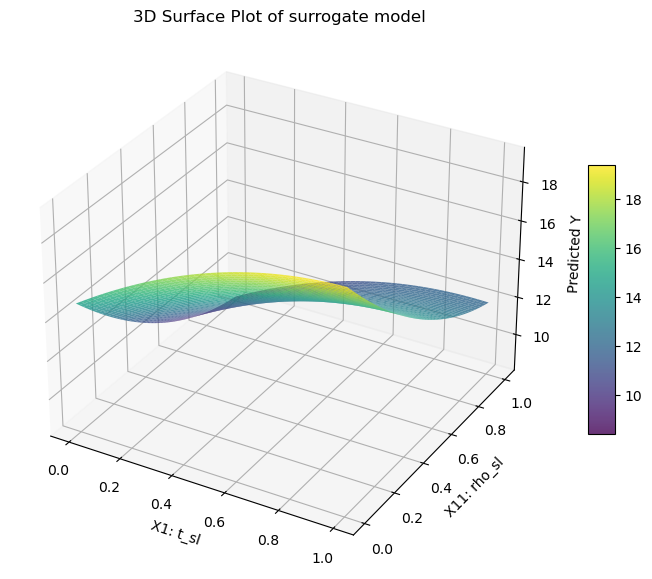

In [14]:
input_name = ['t_sl' ,'t_cor', 't_g', 't_ew', 't_iw',
              'e_sl' ,'e_cor', 'e_g', 'e_ew', 'e_iw',
              'rho_sl' ,'rho_cor', 'rho_g', 'rho_ew', 'rho_iw',
              'soil_vs' ,'soil_rho', 'heig', 'DampR']
FEMU.visualizeSurrogate3D(gpr_fn1_ex220, 19, 0, 10,input_name = input_name)

### Sensitivity analysis

                ST   ST_conf
t_sl      0.314618  0.020706
t_cor     0.005013  0.000442
t_g       0.000953  0.000123
t_ew      0.044238  0.003320
t_iw      0.008779  0.000616
e_sl      0.164451  0.011722
e_cor     0.001233  0.000114
e_g       0.001734  0.000203
e_ew      0.026974  0.002222
e_iw      0.006588  0.000544
rho_sl    0.408457  0.023728
rho_cor   0.000926  0.000100
rho_g     0.001135  0.000134
rho_ew    0.001222  0.000130
rho_iw    0.000782  0.000098
soil_vs   0.000774  0.000093
soil_rho  0.000956  0.000115
heig      0.042832  0.004281
DampR     0.000701  0.000082
                S1   S1_conf
t_sl      0.297553  0.031059
t_cor     0.003057  0.004096
t_g      -0.000511  0.001927
t_ew      0.040625  0.013344
t_iw      0.006562  0.005631
e_sl      0.158282  0.024901
e_cor    -0.001066  0.001909
e_g      -0.003979  0.002468
e_ew      0.018223  0.009273
e_iw      0.003484  0.004585
rho_sl    0.400843  0.032765
rho_cor   0.001014  0.001809
rho_g    -0.001545  0.002420
rho_ew   -0.00

D:\MDSI_project/ANSYS_Building_model/PyAPDL_example/FUNC\func_FEMU.py:205: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(var_name, rotation=90)


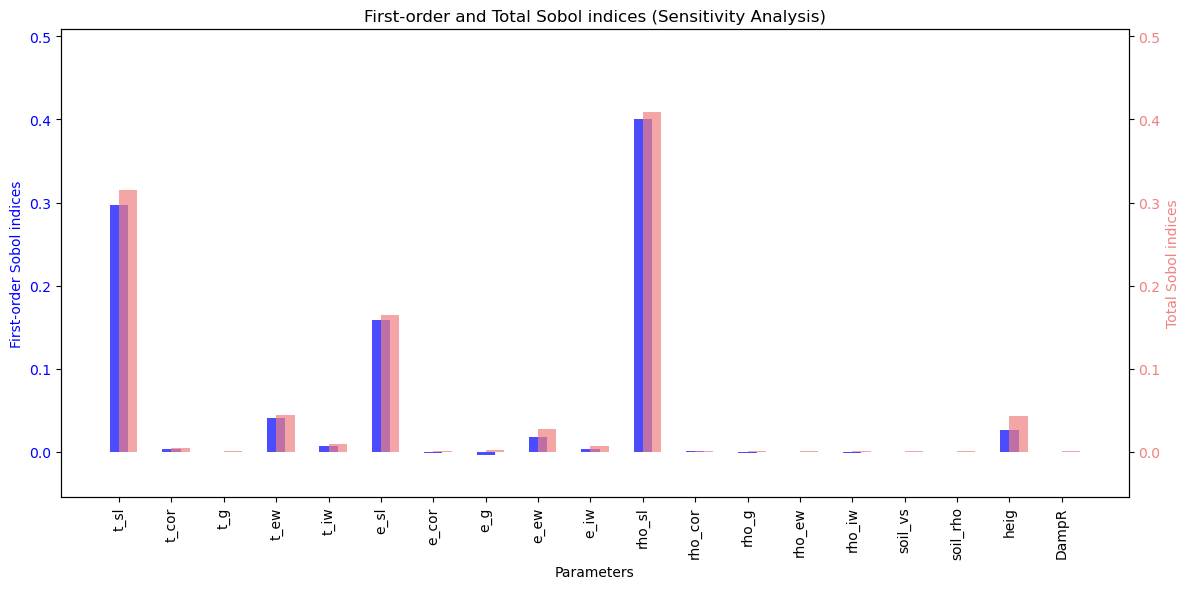

                ST   ST_conf
t_sl      0.463553  0.028052
t_cor     0.007371  0.000802
t_g       0.004870  0.000623
t_ew      0.014430  0.001490
t_iw      0.004954  0.000507
e_sl      0.201892  0.014004
e_cor     0.002586  0.000228
e_g       0.004666  0.000498
e_ew      0.005048  0.000493
e_iw      0.002781  0.000293
rho_sl    0.289414  0.018490
rho_cor   0.003573  0.000370
rho_g     0.002244  0.000234
rho_ew    0.003849  0.000397
rho_iw    0.003341  0.000353
soil_vs   0.003033  0.000338
soil_rho  0.002214  0.000274
heig      0.031147  0.002972
DampR     0.004748  0.000655
                S1   S1_conf
t_sl      0.447653  0.037013
t_cor     0.002935  0.005079
t_g      -0.001817  0.003795
t_ew      0.010178  0.008028
t_iw      0.003728  0.004302
e_sl      0.190100  0.025061
e_cor    -0.000282  0.003654
e_g      -0.002487  0.003775
e_ew      0.002188  0.004209
e_iw      0.000591  0.002643
rho_sl    0.274550  0.029591
rho_cor   0.001467  0.003454
rho_g     0.000463  0.002833
rho_ew    0.00

D:\MDSI_project/ANSYS_Building_model/PyAPDL_example/FUNC\func_FEMU.py:205: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(var_name, rotation=90)


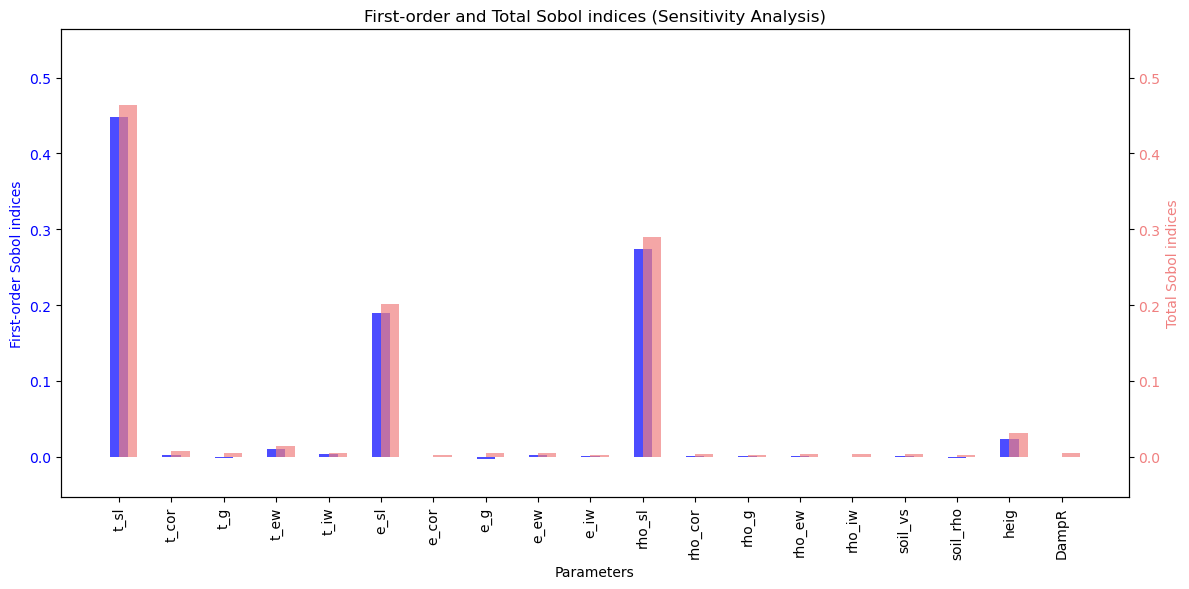

                ST   ST_conf
t_sl      0.272717  0.017775
t_cor     0.005192  0.000476
t_g       0.000822  0.000087
t_ew      0.051354  0.003539
t_iw      0.009629  0.000735
e_sl      0.148673  0.009082
e_cor     0.001265  0.000132
e_g       0.002366  0.000256
e_ew      0.029553  0.002406
e_iw      0.008274  0.000665
rho_sl    0.445558  0.024099
rho_cor   0.000889  0.000094
rho_g     0.001416  0.000161
rho_ew    0.001545  0.000150
rho_iw    0.001594  0.000162
soil_vs   0.001909  0.000225
soil_rho  0.001518  0.000152
heig      0.047615  0.004189
DampR     0.001601  0.000173
                S1   S1_conf
t_sl      0.257918  0.026252
t_cor     0.003067  0.004393
t_g       0.000124  0.001943
t_ew      0.046893  0.012770
t_iw      0.008075  0.005537
e_sl      0.143579  0.022291
e_cor     0.000303  0.002109
e_g       0.002514  0.002935
e_ew      0.022869  0.009781
e_iw      0.007439  0.005447
rho_sl    0.433745  0.036555
rho_cor   0.000310  0.001687
rho_g     0.000622  0.002306
rho_ew    0.00

D:\MDSI_project/ANSYS_Building_model/PyAPDL_example/FUNC\func_FEMU.py:205: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(var_name, rotation=90)


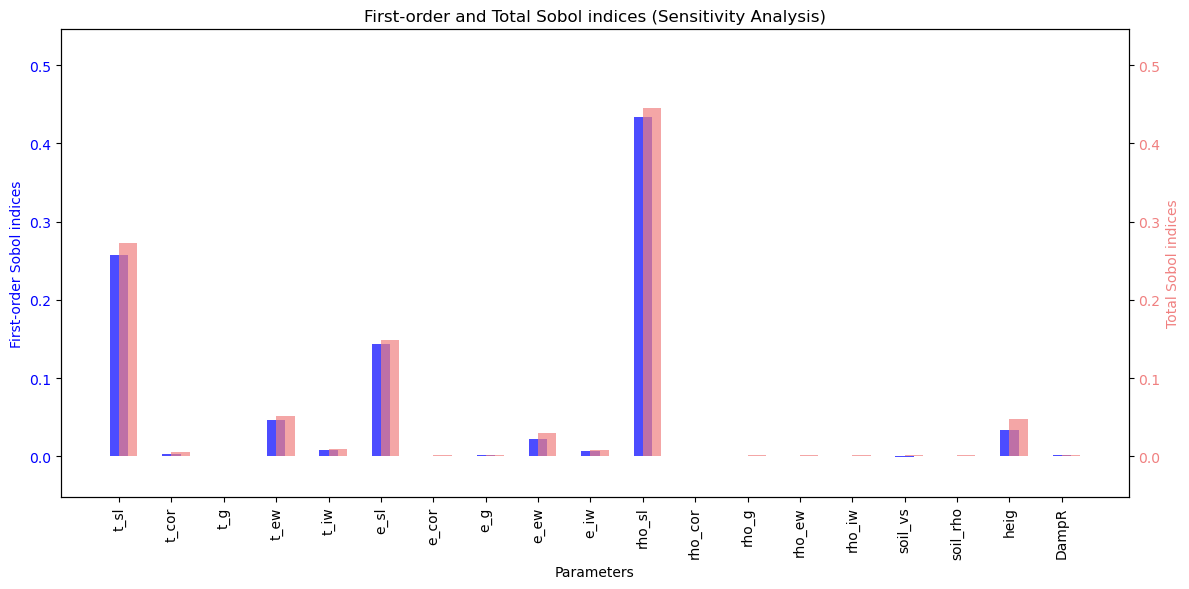

                ST   ST_conf
t_sl      0.513785  0.033091
t_cor     0.007467  0.000836
t_g       0.004798  0.000563
t_ew      0.009350  0.000959
t_iw      0.007733  0.001018
e_sl      0.176445  0.012017
e_cor     0.003726  0.000455
e_g       0.004115  0.000528
e_ew      0.005324  0.000522
e_iw      0.008783  0.001045
rho_sl    0.260496  0.018832
rho_cor   0.006127  0.000705
rho_g     0.004871  0.000538
rho_ew    0.011902  0.001310
rho_iw    0.002175  0.000221
soil_vs   0.003071  0.000340
soil_rho  0.001978  0.000230
heig      0.020303  0.001980
DampR     0.003278  0.000439
                S1   S1_conf
t_sl      0.495824  0.039822
t_cor    -0.000687  0.004849
t_g      -0.000915  0.004760
t_ew      0.006149  0.006300
t_iw      0.004939  0.005421
e_sl      0.167889  0.024174
e_cor    -0.001329  0.003595
e_g      -0.000269  0.003637
e_ew     -0.000003  0.004887
e_iw      0.002390  0.006025
rho_sl    0.234864  0.032062
rho_cor  -0.000083  0.004909
rho_g     0.001658  0.004315
rho_ew    0.00

D:\MDSI_project/ANSYS_Building_model/PyAPDL_example/FUNC\func_FEMU.py:205: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(var_name, rotation=90)


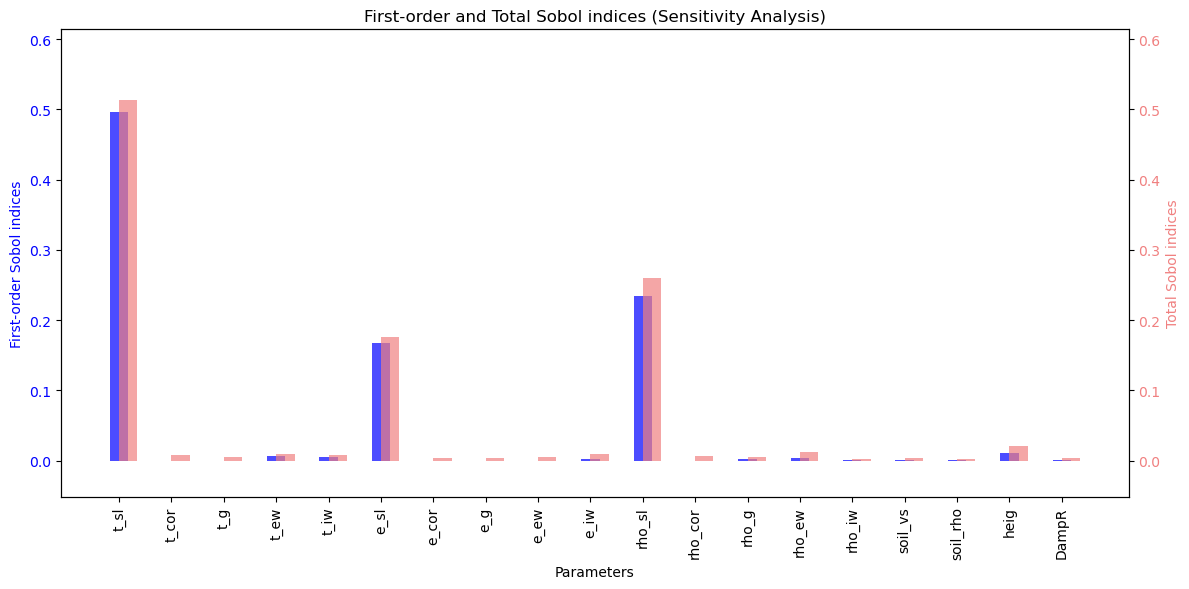

In [11]:
input_name = ['t_sl' ,'t_cor', 't_g', 't_ew', 't_iw',
              'e_sl' ,'e_cor', 'e_g', 'e_ew', 'e_iw',
              'rho_sl' ,'rho_cor', 'rho_g', 'rho_ew', 'rho_iw',
              'soil_vs' ,'soil_rho', 'heig', 'DampR']
Si_fn1_ex22 =  FEMU.sobol_GSA(gpr_fn1_ex22,19,2048,input_name,True)
Si_fn2_ex22 =  FEMU.sobol_GSA(gpr_fn2_ex22,19,2048,input_name,True)

#Si_fn1_ex221 =  FEMU.sobol_GSA(gpr_fn1_ex221,19,2048,input_name,True)
#Si_fn2_ex221 =  FEMU.sobol_GSA(gpr_fn2_ex221,19,2048,input_name,True)

Si_fn1_ex220 =  FEMU.sobol_GSA(gpr_fn1_ex220,19,2048,input_name,True)
Si_fn2_ex220 =  FEMU.sobol_GSA(gpr_fn2_ex220,19,2048,input_name,True)

### Optimization by GA

$x = argmin \sum_{i=1}^{3}(w_{1}^{i}*(f_{n1,gpr}^{i}-f_{n1,exp}^{i}))^2 + (w_{2}^{i}*(f_{n2,gpr}^{i}-f_{n2,exp}^{i}))^2 $ where $i$ indicates the index of impact tests.

$w_{1}^i = 100$ for $i = 1 \cdots 3$, 

$w_{2}^1 =  w_{2}^3 = 100$ and $w_{2}^2 = 100$ , 

In [15]:
import numpy as np
from scipy.optimize import minimize
from deap import base, creator, tools, algorithms
from scipy.stats import qmc

# Example surrogate models (replace with your actual GPR models)
def surrogate_fn1_ex22(inputs):
    
    # GPR model for fn1 (natural frequency 1)
    return gpr_fn1_ex22.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex22(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex22.predict(inputs.reshape(1, -1))[0]

def surrogate_fn1_ex220(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn1_ex220.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex220(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex220.predict(inputs.reshape(1, -1))[0]

def surrogate_fn1_ex221(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn1_ex221.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex221(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex221.predict(inputs.reshape(1, -1))[0]

# Objective function: minimize the difference from target
def objective_function(x_):
    #x = np.array(x)
    x = 0.5*np.ones(19)
    x[0] = x_[0]
    x[3] = x_[1]
    x[4] = x_[2]
    x[5] = x_[3]
    x[8] = x_[4]
    x[9] = x_[5]
    x[10] = x_[6]
    x[17] = x_[7]
    fn1_pred_ex22 = surrogate_fn1_ex22(x)
    fn2_pred_ex22 = surrogate_fn2_ex22(x)
    fn1_pred_ex220 = surrogate_fn1_ex220(x)
    fn2_pred_ex220 = surrogate_fn2_ex220(x)
    #fn1_pred_ex221 = surrogate_fn1_ex221(x)
    #fn2_pred_ex221 = surrogate_fn2_ex221(x)
    #return ((100*(fn1_pred_ex22 - mean_fn_1_exp_ex22))**2 + (100*(fn2_pred_ex22 - mean_fn_2_exp_ex22))**2 + (100*(fn1_pred_ex220 - mean_fn_1_exp_ex220))**2 + (100*(fn2_pred_ex220 - mean_fn_2_exp_ex220))**2 +(100*(fn1_pred_ex221 - mean_fn_1_exp_ex221))**2 + (100*(fn2_pred_ex221 - mean_fn_2_exp_ex221))**2,)
    return ((100*(fn1_pred_ex22 - mean_fn_1_exp_ex22))**2 + (100*(fn2_pred_ex22 - mean_fn_2_exp_ex22))**2 + (100*(fn1_pred_ex220 - mean_fn_1_exp_ex220))**2 + (100*(fn2_pred_ex220 - mean_fn_2_exp_ex220))**2,)

bounds = [(0, 1) for _ in range(8)]  # Example bounds

# Remaining significant parameter: 0,3,4,5,8,10,15,16,17
# Using correlation: 0,3,5,8,9,10,17,18
#bounds[0 ]  = (0,1)
#bounds[3 ]  = (0,1)
#bounds[4 ]  = (0,1)
#bounds[5 ]  = (0,1)
#bounds[8 ]  = (0,1)
#bounds[10] = (0,1)
#bounds[15] = (0,1)
#bounds[16] = (0,1)
bounds[7] = (0.3,0.7)

# Define parameter bounds (example: [(low1, high1), (low2, high2), ...])
#bounds = [(0, 10), (50, 100), (0.1, 1.0)]  # Example bounds for each parameter
num_params = len(bounds)
population_size = 4000  # Define population size

# Generate LHS samples
sampler = qmc.LatinHypercube(d=num_params)  # d = number of parameters
lhs_samples = sampler.random(n=population_size+1)  # Generate population_size samples
scaled_samples = qmc.scale(lhs_samples, [b[0] for b in bounds], [b[1] for b in bounds])  # Scale to bounds

# Custom parameter generator using LHS
lhs_population = scaled_samples.tolist()  # Convert to a list of lists
print(np.shape(lhs_population))
def generate_individual():
    """Populates from the pre-generated LHS samples."""
    if not lhs_population:
        raise ValueError("LHS population is exhausted! Increase the number of samples.")
    return lhs_population.pop(0)

# Define the fitness function (minimization problem)
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimize
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, generate_individual)  # Individual generator
toolbox.register("population", tools.initRepeat, list, toolbox.individual)  # Population generator

# Register genetic operators
toolbox.register("evaluate", objective_function)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Population size and generations
population = toolbox.population(n=population_size)  # Population of 100 individuals

# Run the genetic algorithm
num_generations = 500
result_population, log = algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.2, ngen=num_generations, 
                                             stats=None, halloffame=None, verbose=True)

# Evaluate all individuals and sort them
evaluated_population = [(ind, objective_function(ind)) for ind in result_population]
sorted_population = sorted(evaluated_population, key=lambda x: x[1])  # Sort by fitness

# Top 10 candidates
top_10_candidates = sorted_population[:30]

# Print the results
for idx, (candidate, score) in enumerate(top_10_candidates):
    print(f"Rank {idx+1}: Parameters = {candidate}, Objective = {score}")




(4001, 8)


c:\Users\v196m\anaconda3\envs\opt2\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\v196m\anaconda3\envs\opt2\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals
0  	4000  
1  	3040  
2  	3075  
3  	3016  
4  	2968  
5  	3105  
6  	3105  
7  	3094  
8  	3051  
9  	3025  
10 	3079  
11 	3044  
12 	3073  
13 	3043  
14 	3041  
15 	3069  
16 	3107  
17 	2988  
18 	3031  
19 	3068  
20 	3046  
21 	2990  
22 	3004  
23 	3037  
24 	3032  
25 	3051  
26 	3054  
27 	3025  
28 	3005  
29 	3058  
30 	3043  
31 	2998  
32 	3041  
33 	3050  
34 	3085  
35 	3065  
36 	3071  
37 	3028  
38 	3087  
39 	3005  
40 	3056  
41 	3028  
42 	3044  
43 	3038  
44 	3020  
45 	3081  
46 	3001  
47 	3016  
48 	3061  
49 	3034  
50 	3046  
51 	3083  
52 	3025  
53 	3026  
54 	2982  
55 	3002  
56 	3090  
57 	3032  
58 	3099  
59 	3037  
60 	3006  
61 	3068  
62 	2984  
63 	3032  
64 	3010  
65 	3049  
66 	3011  
67 	3040  
68 	3071  
69 	3045  
70 	3068  
71 	3011  
72 	3027  
73 	3084  
74 	3058  
75 	2998  
76 	3011  
77 	2999  
78 	3032  
79 	3017  
80 	3006  
81 	3033  
82 	3043  
83 	3072  
84 	3072  
85 	3065  
86 	3090  
87 	2966  
88 	3078  
89 	3020  

In [ ]:
# For NoSSI

#Rank 1: Parameters = [0.9176086776693746, 0.16317562400756097, 0.31932366147056507, 0.7837649344018447, 0.12577778537353324, 0.3982629371007186, 0.7756282026671792, 0.5167268383855259], Objective = (1.1074849945904939,)


### OPtimization by L-BFGS-B

In [17]:
import numpy as np
from scipy.optimize import minimize


# GA result 0.8430186936984674, 0.5013464881374452, 0.1892947179164055, 0.7586169481399572, 0.21266063482968273, 0.6611568296555667, 0.3488986399993419, 0.3474469743092435, 0.5459044097848611
# Example surrogate models (replace with your actual GPR models)
def surrogate_fn1_ex22(inputs):
    # GPR model for fn1 (natural frequency 1)
    return gpr_fn1_ex22.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex22(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex22.predict(inputs.reshape(1, -1))[0]

def surrogate_fn1_ex220(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn1_ex220.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex220(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex220.predict(inputs.reshape(1, -1))[0]

def surrogate_fn1_ex221(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn1_ex221.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex221(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex221.predict(inputs.reshape(1, -1))[0]

# Objective function: minimize the difference from target
def objective_function(x):
    fn1_pred_ex22 = surrogate_fn1_ex22(x)
    fn2_pred_ex22 = surrogate_fn2_ex22(x)
    fn1_pred_ex220 = surrogate_fn1_ex220(x)
    fn2_pred_ex220 = surrogate_fn2_ex220(x)
    #fn1_pred_ex221 = surrogate_fn1_ex221(x)
    #fn2_pred_ex221 = surrogate_fn2_ex221(x)
    #return (100*(fn1_pred_ex22 - mean_fn_1_exp_ex22))**2 + (100*(fn2_pred_ex22 - mean_fn_2_exp_ex22))**2 + (100*(fn1_pred_ex220 - mean_fn_1_exp_ex220))**2 + (50*(fn2_pred_ex220 - mean_fn_2_exp_ex220))**2 +(1000*(fn1_pred_ex221 - mean_fn_1_exp_ex221))**2 + (1000*(fn2_pred_ex221 - mean_fn_2_exp_ex221))**2
    #return ((fn1_pred - 12.1344)**2) + ((fn2_pred - 18.8672)**2)
    return (100*(fn1_pred_ex22 - mean_fn_1_exp_ex22))**2 + (100*(fn2_pred_ex22 - mean_fn_2_exp_ex22))**2 + (100*(fn1_pred_ex220 - mean_fn_1_exp_ex220))**2 + (50*(fn2_pred_ex220 - mean_fn_2_exp_ex220))**2
# 
# Bounds for the 19 parameters (adjust as per your problem)
bounds = [(0.5, 0.5) for _ in range(19)]  # Example bounds

bounds[0]  = (0,1)
bounds[3]  = (0,1)
bounds[4]  = (0,1)
bounds[5]  = (0,1)
bounds[8]  = (0,1)
bounds[9]  = (0,1)
bounds[10] = (0,1)
bounds[17] = (0,1)

# Initial guess for the parameters
#x0 = np.random.uniform(0, 1 ,size=19)
id_ = 0
x0 = 0.5*np.ones(19)


x0[0]  = top_10_candidates[id_][0][0]
x0[3]  = top_10_candidates[id_][0][1]
x0[4]  = top_10_candidates[id_][0][2]
x0[5]  = top_10_candidates[id_][0][3]
x0[8]  = top_10_candidates[id_][0][4]
x0[9]  = top_10_candidates[id_][0][5]
x0[10] = top_10_candidates[id_][0][6]
x0[17] = top_10_candidates[id_][0][7]

#x0 = top_10_candidates[5][0]

x_top_10_candidates = np.zeros([10,19])
print(x0)

for i_top in range(1):
    # Perform optimization
    result = minimize(objective_function, x0, bounds=bounds, method='L-BFGS-B')

    # Optimized parameters
    if result.success:
        optimized_params = result.x
        print("Optimized Parameters:", optimized_params)
        print("Objective Function Value:", result.fun)
        print(f"goal fn_1:{mean_fn_1_exp_ex22}, fn_2:{mean_fn_2_exp_ex22}")
        print(f"fn_1: {surrogate_fn1_ex22(result.x)}, fn_2: {surrogate_fn2_ex22(result.x)}")
        print(f"goal fn_1:{mean_fn_1_exp_ex220}, fn_2:{mean_fn_2_exp_ex220}")
        print(f"fn_1: {surrogate_fn1_ex220(result.x)}, fn_2: {surrogate_fn2_ex220(result.x)}")
        print(f"goal fn_1:{mean_fn_1_exp_ex221}, fn_2:{mean_fn_2_exp_ex221}")
        print(f"fn_1: {surrogate_fn1_ex221(result.x)}, fn_2: {surrogate_fn2_ex221(result.x)}")
        x_top_10_candidates[i_top,:] = result.x
        
    else:
        print("Optimization failed:", result.message)

# Identify rows that are not all zeros
non_zero_rows = ~np.all(x_top_10_candidates == 0, axis=1)
# Remove rows with all zeros
x_top_10_candidates = x_top_10_candidates[non_zero_rows]
x_top_10_candidates = np.unique(x_top_10_candidates, axis=0)
print(x_top_10_candidates)


[0.91760868 0.5        0.5        0.16317562 0.31932366 0.78376493
 0.5        0.5        0.12577779 0.39826294 0.7756282  0.5
 0.5        0.5        0.5        0.5        0.5        0.51672684
 0.5       ]
Optimized Parameters: [0.91831499 0.5        0.5        0.15683994 0.31580221 0.77003739
 0.5        0.5        0.10753501 0.39957796 0.7630694  0.5
 0.5        0.5        0.5        0.5        0.5        0.49754582
 0.5       ]
Objective Function Value: 3.082655915597166e-08
goal fn_1:12.1344, fn_2:18.8672
fn_1: 12.134401181943247, fn_2: 18.86719987469244
goal fn_1:12.1856, fn_2:19.200000000000003
fn_1: 12.185598745702094, fn_2: 19.200000621935217
goal fn_1:12.2112, fn_2:18.8672
fn_1: 12.22115898117831, fn_2: 0.00011763076415151467
[[0.91831499 0.5        0.5        0.15683994 0.31580221 0.77003739
  0.5        0.5        0.10753501 0.39957796 0.7630694  0.5
  0.5        0.5        0.5        0.5        0.5        0.49754582
  0.5       ]]


In [ ]:
# For No SSI

#Optimized Parameters: [0.91831499 0.5        0.5        0.15683994 0.31580221 0.77003739
# 0.5        0.5        0.10753501 0.39957796 0.7630694  0.5
# 0.5        0.5        0.5        0.5        0.5        0.49754582
# 0.5       ]

### Correlation Matrix Heatmap

In [ ]:
# Compute the correlation matrix
correlation_matrix = np.corrcoef(x_top_10_candidates, rowvar=False)

import seaborn as sns
import matplotlib.pyplot as plt

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix Heatmap")
plt.show()

### Checking the effects that vary the non-significant parameters

In [ ]:
def surrogate_fn1_ex22(inputs):
    # GPR model for fn1 (natural frequency 1)
    return gpr_fn1_ex22.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex22(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex22.predict(inputs.reshape(1, -1))[0]

def surrogate_fn1_ex220(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn1_ex220.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex220(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex220.predict(inputs.reshape(1, -1))[0]

def surrogate_fn1_ex221(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn1_ex221.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex221(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex221.predict(inputs.reshape(1, -1))[0]

# Objective function: minimize the difference from target
def objective_function_fn(x):
    penalty_w = 10
    x = np.array(x)
    fn1_pred_ex22 = surrogate_fn1_ex22(x)
    fn2_pred_ex22 = surrogate_fn2_ex22(x)
    fn1_pred_ex220 = surrogate_fn1_ex220(x)
    fn2_pred_ex220 = surrogate_fn2_ex220(x)
    #fn1_pred_ex221 = surrogate_fn1_ex221(x)
    #fn2_pred_ex221 = surrogate_fn2_ex221(x)
    #print(fn1_pred_ex22,fn2_pred_ex22,fn1_pred_ex220,fn2_pred_ex220,fn1_pred_ex221,fn2_pred_ex221)
    total_error = ((mean_fn_1_exp_ex22))**2 + ((mean_fn_2_exp_ex22))**2 + ((mean_fn_1_exp_ex220))**2 + ((mean_fn_2_exp_ex220))**2 +((mean_fn_1_exp_ex221))**2 + ((mean_fn_2_exp_ex221))**2
    return ((penalty_w*(fn1_pred_ex22 - mean_fn_1_exp_ex22))**2 + (penalty_w*(fn2_pred_ex22 - mean_fn_2_exp_ex22))**2 + (penalty_w*(fn1_pred_ex220 - mean_fn_1_exp_ex220))**2 + (penalty_w*(fn2_pred_ex220 - mean_fn_2_exp_ex220))**2 +(penalty_w*(fn1_pred_ex221 - mean_fn_1_exp_ex221))**2 + (penalty_w*(fn2_pred_ex221 - mean_fn_2_exp_ex221))**2)/total_error


x0 = np.array(x_top_10_candidates)[0]
for i in range(30):
    x0[1]  = np.random.rand()
    x0[2]  = np.random.rand()
    x0[6]  = np.random.rand()
    x0[7]  = np.random.rand()
    x0[9]  = np.random.rand()
    x0[11] = np.random.rand()
    x0[12] = np.random.rand()
    x0[13] = np.random.rand()
    x0[14] = np.random.rand()
    x0[18] = np.random.rand()
    print(objective_function_fn(x0))


### Run the simulation for comparison the optmizaed result and expiremental data
- we might need futher optimization process for fine-tunning

In [5]:
simu_tk = simulation_PyAPDL(nproc=4,nerr=10000)
simu_tk.launch_engine()
simu_tk.mapdl.clear()

PyMAPDL is taking longer than expected to connect to an MAPDL session.
Checking if there are any available licenses...
Launch Pymapdl
     Launch Pymapdl successfully, duration 15.0828 seconds.


### Objecttive function for comparison with expirmental data for GP

#### Note of $H_{simu}$ and $H_{exp}$
- In the further GP optimization for the whole FRFs, we will compare the FRFs from 8 channels on the slab at 1OG and 2OG from simulation to exp data. Since we have 3 events, i.e. ex22, ex220, ex221, therefore we will have totally 3(evnets) * 8(channels) = 24 FRFs for whole hammer testings.
- The $H_{simu}$ and $H_{exp}$ are the FRFs from simulation and exp respectively. Each of them have the size [i, N], where the $N$ is the length of the frequency series and $i$ is the index of channels based on each evnets.
  - The index $i$ of rows (axis = 1) following the sequences: $ i = 0 \cdots 7$ is for channels [9,10,11,12,3,13,14,15] for event ex221.
  - The index $i$ of rows (axis = 1) following the sequences: $ i = 8 \cdots 15$ is for channels [9,10,11,12,3,13,14,15] for event ex220. 
  - The index $i$ of rows (axis = 1) following the sequences: $ i = 16 \cdots 13$ is for channels [9,10,11,12,3,13,14,15] for event ex22.

#### Normalization of $H_{simu}$ and $H_{exp}$

- Normalized based on each events. Therefore the normalization of $ i = 0 \cdots 7$,  $ i = 8 \cdots 15$ and $ i = 16 \cdots 13$ are seperated.





2.1302661857943243e-12
 Setting information
     Building inner wall           :  True
     Building stair                :  True
     Building SSI                  :  False
     Element size                  :  0.4
     Height of building            :  3.3617294134
 Assigning parameter
     Rewrite thickness by input
     Rewrite Young's modulus by input
     Rewrite Poisson's ratio by input
     Rewrite Density by input
     Rewrite soil properties by input
 /PREP7 activated
     /PREP7 finished, duration 7.1328 seconds.
Solve model: /SOLU
 Setting information
     Solution type                 :  6
     Start frequency               :  0.001
     End frequency                 :  40
     Freqency increment            :  1
     Number of modes (solu_type=2) :  40
     Damping ratio                 :  0.045
     Excitation node               :  4147
Using Modal-superpostion method
     /SOLU finished, duration 26.0392 seconds.
 Extract all modal information , duration 4.6812 seconds.
 

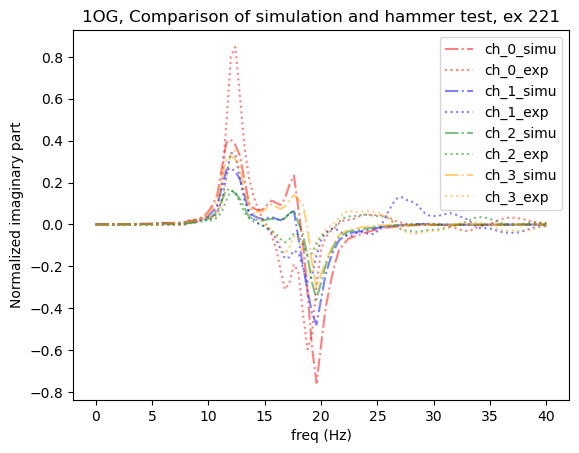

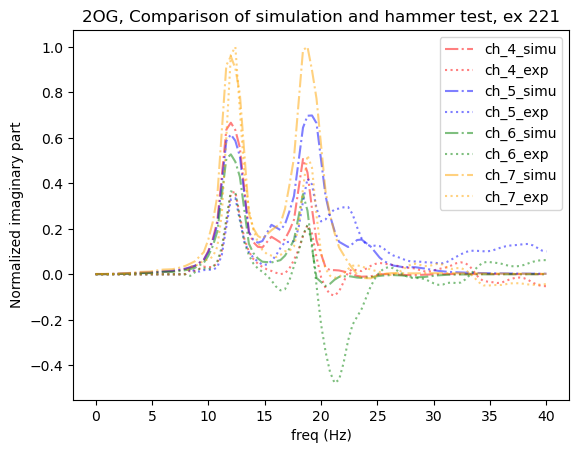

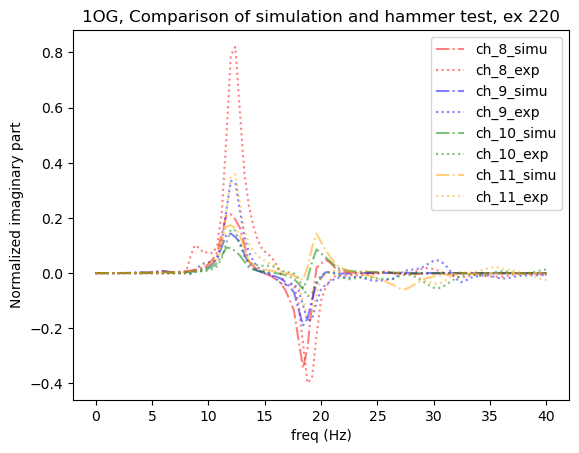

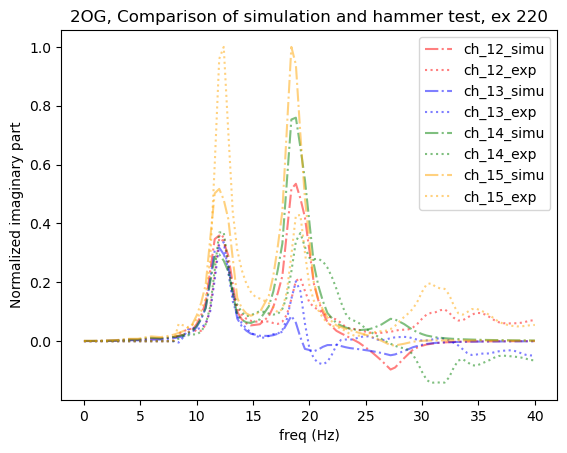

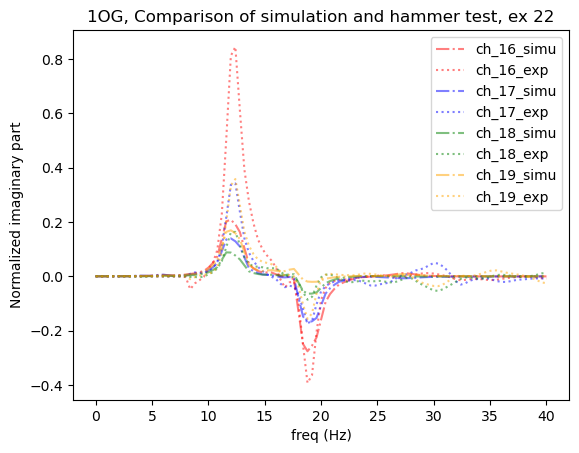

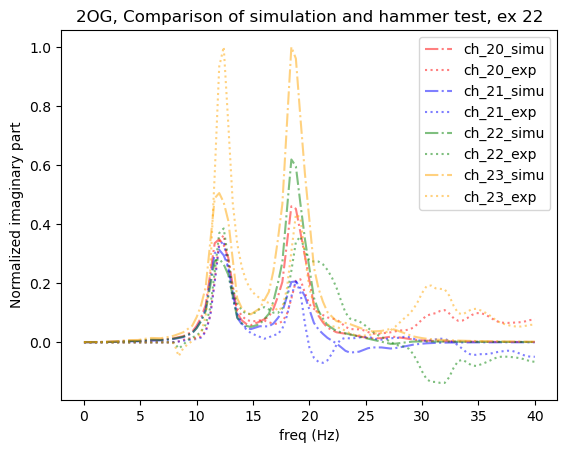

0.9701323649030135
2.1302661857943243e-12
0.9701323649051438


(0.9701323649030135,
 array([[ 0.00029329,  0.00029329,  0.00029329, ..., -0.00087987,
         -0.00087987, -0.00087987],
        [ 0.00029329,  0.00029329,  0.00029329, ..., -0.00058658,
         -0.00058658, -0.00058658],
        [ 0.        ,  0.        ,  0.        , ..., -0.00053369,
         -0.00041349, -0.00029329],
        ...,
        [ 0.00050598,  0.00050598,  0.00050598, ...,  0.0001265 ,
          0.0001265 ,  0.0001265 ],
        [ 0.00063248,  0.00063248,  0.00063248, ...,  0.00111564,
          0.0010638 ,  0.00101196],
        [ 0.00113846,  0.00113846,  0.00113846, ...,  0.00248428,
          0.00238059,  0.00227691]]))

In [6]:
import os
from IPython.display import clear_output

def surrogate_fn1_ex22(inputs):
    # GPR model for fn1 (natural frequency 1)
    return gpr_fn1_ex22.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex22(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex22.predict(inputs.reshape(1, -1))[0]

def surrogate_fn1_ex220(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn1_ex220.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex220(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex220.predict(inputs.reshape(1, -1))[0]

def surrogate_fn1_ex221(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn1_ex221.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex221(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex221.predict(inputs.reshape(1, -1))[0]

# Objective function: minimize the difference from target
def objective_function_fn(x):
    penalty_w = 25
    fn1_pred_ex22 = surrogate_fn1_ex22(x)
    fn2_pred_ex22 = surrogate_fn2_ex22(x)
    fn1_pred_ex220 = surrogate_fn1_ex220(x)
    fn2_pred_ex220 = surrogate_fn2_ex220(x)
    #fn1_pred_ex221 = surrogate_fn1_ex221(x)
    #fn2_pred_ex221 = surrogate_fn2_ex221(x)
    total_error = ((mean_fn_1_exp_ex22))**2 + ((mean_fn_2_exp_ex22))**2 + ((mean_fn_1_exp_ex220))**2 + ((mean_fn_2_exp_ex220))**2 
    return ((penalty_w*(fn1_pred_ex22 - mean_fn_1_exp_ex22))**2 + (penalty_w*(fn2_pred_ex22 - mean_fn_2_exp_ex22))**2 + (penalty_w*(fn1_pred_ex220 - mean_fn_1_exp_ex220))**2 + (penalty_w*(fn2_pred_ex220 - mean_fn_2_exp_ex220))**2 )/total_error

def objective_function(X_input):
    
    fn_error = objective_function_fn(X_input)
    print(fn_error)
    cut_freq_low = 8
    cut_freq_high = 40
    vary_ratio = 0.5
    X_transformed = 2 * X_input - 1
    X_transformed = X_transformed.reshape(-1,1)
    X_transformed = np.transpose(X_transformed)
    i_doe = 0
    X_doe_transformed = X_transformed
    #
    # Parameter list    = [slab ,corridor, ground, edge_wall, inner_wall, stair ]
    # Parameter list    = [ vs,   rho,   nu ]
    t_para   = np.array([ 0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0],
                        0.8  + vary_ratio*(0.8  )*X_transformed[i_doe,1],
                        0.05 + vary_ratio*(0.05 )*X_transformed[i_doe,2],
                        0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,3],
                        0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,4],
                        0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0]])
    #
    e_para   = np.array([ 20e9 + vary_ratio*20e9*X_transformed[i_doe,5],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,6],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,7],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,8],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,9],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,5]])
    #
    nu_para  = np.array([ 0.27,
                        0.27,
                        0.27,
                        0.27,
                        0.27,
                        0.27])
    #
    rho_para = np.array([ 2300 + vary_ratio*2300*X_transformed[i_doe,10],
                        2300 + vary_ratio*2300*X_transformed[i_doe,11],
                        2300 + vary_ratio*2300*X_transformed[i_doe,12],
                        2300 + vary_ratio*2300*X_transformed[i_doe,13],
                        2300 + vary_ratio*2300*X_transformed[i_doe,14],
                        2300 + vary_ratio*2300*X_transformed[i_doe,10]])
    #
    soil_para = np.array([ 350  + vary_ratio*(350 )*X_transformed[i_doe,15],
                        1400 + vary_ratio*(1400)*X_transformed[i_doe,16],
                        0.33 ])
    #
    height_b            = 3.37 + vary_ratio*3.37*X_transformed[i_doe,17]
    damp_ratio_b        = 0.045+ 0.01*X_transformed[i_doe,18]
    tol = 0.3
    #
    #
    # Start the simulation 
    simu_tk.mapdl.clear()
    simu_tk.setting_parameter(bool_SSI= False,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()
    # Excitation point: Hammer 2.1 Pos1 (close to edge)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',12.776-tol,12.776+tol)
    nsel_id_3 = simu_tk.mapdl.nsel('R','LOC','Y',2.748-tol,2.748+tol)
    simu_tk.mapdl.nsel('ALL')
    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=cut_freq_high,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_3[1])
    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
    ## Get FRF at target point
    meas_FRFs_ex221 = simu_tk.get_FRFs_meas_EXAMPLE()
    DOE_info_ex221 = {
        'id':i_doe,
        'X':X_input.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs_ex221
        }
    simu_tk.mapdl.clear()
    #
    #
    simu_tk.setting_parameter(bool_SSI= False,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()
    # Excitation point: Hammer 2.0 Pos2 (sensor)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',7.19-tol,7.19+tol)
    nsel_id_2 = simu_tk.mapdl.nsel('R','LOC','Y',8.14-tol,8.14+tol)
    simu_tk.mapdl.nsel('ALL')
    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=cut_freq_high,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_2[1])
    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
    ## Get FRF at target point
    meas_FRFs_ex220 = simu_tk.get_FRFs_meas_EXAMPLE()
    DOE_info_ex220 = {
        'id':i_doe,
        'X':X_input.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs_ex220
        }
    simu_tk.mapdl.clear()
    #
    #
    simu_tk.setting_parameter(bool_SSI= False,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()
    # Excitation point: Hammer 2.0 Pos1 (shaker)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',9.3-tol,9.3+tol)
    nsel_id_1 = simu_tk.mapdl.nsel('R','LOC','Y',5.9-tol,5.9+tol)
    simu_tk.mapdl.nsel('ALL')
    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=cut_freq_high,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_1[1])
    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
    ## Get FRF at target point
    meas_FRFs_ex22 = simu_tk.get_FRFs_meas_EXAMPLE()
    DOE_info_ex22 = {
        'id':i_doe,
        'X':X_input.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs_ex22
        }
    #
    simu_tk.mapdl.clear()
    #clear_output(wait=True)
    #
    freq_resample = np.linspace(0, cut_freq_high, 101)
    FRFs_simu = np.zeros([24,len(freq_resample)])
    #
    i_ch_index = 0
    ch_list = [9,10,11,12,3,13,14,15]
    # Case 221
    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(DOE_info_ex221['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(DOE_info_ex221['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1
    # Case 220
    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(DOE_info_ex220['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(DOE_info_ex220['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1
    # Case 22
    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(DOE_info_ex22['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(DOE_info_ex22['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1
    #
    # Split into 3 groups of [8, 101]
    num_groups = 3
    group_size = 8
    normalized_data = np.zeros_like(FRFs_simu)
    #
    for i in range(num_groups):
        # Get the current group
        start_idx = i * group_size
        end_idx = start_idx + group_size
        group = FRFs_simu[start_idx:end_idx, :]  # Shape: [8, 101]
        # Compute normalization value (e.g., max of the group)
        normalization_value = np.max(np.abs(group))
        # Normalize the group
        normalized_data[start_idx:end_idx, :] = group / normalization_value
    #FRFs_simu_norm = FRFs_simu/np.max(np.abs(FRFs_simu))
    FRFs_simu_norm = normalized_data
    #
    #
    ####################################################################################################################################################
    # Import measurement data
    FRFs_exp = np.zeros([24,len(freq_resample)])
    #
    i_pos_1OG = [9,10,11,12,3,13,14,15]
    #cut_freq_low = 8
    #cut_freq_high = 50
    #
    i_file = 9
    directory = os.path.join(project_dir, "MATLAB/Surrogate_main/FRF/")
    for i in range(len(i_pos_1OG)):
        i_pos = i_pos_1OG[i]
        filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
        full_path = os.path.join(directory, filename)
        frf_data = sio.loadmat(full_path)
        f = np.array([frf_data["freq_"]])[0]
        #r = np.array([frf_data["real_"]])[0]
        imag = np.array([frf_data["imag_"]])[0]
        indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
        indices_cutoff_high = np.where((f >= 40 ))[0]
        id_last = indices[-1] 
        id_start = indices[0] 
        f = f[0:id_last]
        #r = r[0:id_last]
        imag = imag[0:id_last]
        imag[0: id_start] = 0
        imag[indices_cutoff_high[0]:id_last] = 0
        i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
        FRFs_exp[i,:] = i_resample
    #
    i_file = 1
    for i in range(len(i_pos_1OG)):
        i_pos = i_pos_1OG[i]
        filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
        full_path = os.path.join(directory, filename)
        frf_data = sio.loadmat(full_path)
        f = np.array([frf_data["freq_"]])[0]
        #r = np.array([frf_data["real_"]])[0]
        imag = np.array([frf_data["imag_"]])[0]
        indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
        indices_cutoff_high = np.where((f >= 40 ))[0]
        id_last = indices[-1] 
        id_start = indices[0] 
        f = f[0:id_last]
        #r = r[0:id_last]
        imag = imag[0:id_last]
        imag[0: id_start] = 0
        imag[indices_cutoff_high[0]:id_last] = 0
        i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
        FRFs_exp[i+8,:] = i_resample
    #
    i_file = 13
    for i in range(len(i_pos_1OG)):
        i_pos = i_pos_1OG[i]
        filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
        full_path = os.path.join(directory, filename)
        frf_data = sio.loadmat(full_path)
        f = np.array([frf_data["freq_"]])[0]
        #r = np.array([frf_data["real_"]])[0]
        imag = np.array([frf_data["imag_"]])[0]
        indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
        indices_cutoff_high = np.where((f >= 40 ))[0]
        id_last = indices[-1] 
        id_start = indices[0] 
        f = f[0:id_last]
        #r = r[0:id_last]
        imag = imag[0:id_last]
        imag[0: id_start] = 0
        imag[indices_cutoff_high[0]:id_last] = 0
        i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
        FRFs_exp[i+16,:] = i_resample
    #
    # Split into 3 groups of [8, 101]
    num_groups = 3
    group_size = 8
    normalized_data = np.zeros_like(FRFs_exp)
    #
    for i in range(num_groups):
        # Get the current group
        start_idx = i * group_size
        end_idx = start_idx + group_size
        group = FRFs_exp[start_idx:end_idx, :]  # Shape: [8, 101]
        # Compute normalization value (e.g., max of the group)
        normalization_value = np.max(np.abs(group))
        # Normalize the group
        normalized_data[start_idx:end_idx, :] = group / normalization_value
    #FRFs_simu_norm = FRFs_simu/np.max(np.abs(FRFs_simu))
    FRFs_exp_norm = normalized_data
    #FRFs_exp_norm = FRFs_exp/np.max(np.abs(FRFs_exp))
    #
    #
    error = (FRFs_simu_norm - FRFs_exp_norm)**2

    # Define frequency ranges and factors
    ranges_and_factors = [
        ((14, 17), 10),  # Apply factor 5 to the range [21, 30]
        ((21, 50), 10)   # Apply factor 2 to the range [40, 50]
    ]

    # Generate the mask
    mask = FEMU.generate_mask(freq_resample, ranges_and_factors)
    error = error*mask
    error_percentage = np.sum(error)/np.sum(2*(FRFs_exp_norm)**2)
    #
    color_list = ['red', 'blue', 'green', 'orange']

    for i in range(0,4):
        #plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="--",color='blue', alpha=0.5)
        plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="-.",color=color_list[i], alpha=0.5)
        plt.plot(freq_resample,FRFs_exp_norm[i,:], label=f"ch_{i}_exp",linestyle=":",color=color_list[i], alpha=0.5)
        plt.legend()
        plt.xlabel("freq (Hz)")
        plt.ylabel("Normalized imaginary part")
        plt.title("1OG, Comparison of simulation and hammer test, ex 221")
    plt.show()
    for i in range(4,8):
        #plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="--",color='blue', alpha=0.5)
        plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="-.",color=color_list[i-4], alpha=0.5)
        plt.plot(freq_resample,FRFs_exp_norm[i,:], label=f"ch_{i}_exp",linestyle=":",color=color_list[i-4], alpha=0.5)
        plt.legend()
        plt.xlabel("freq (Hz)")
        plt.ylabel("Normalized imaginary part")
        plt.title("2OG, Comparison of simulation and hammer test, ex 221")
    plt.show()
    for i in range(8,12):
        #plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="--",color='blue', alpha=0.5)
        plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="-.",color=color_list[i-8], alpha=0.5)
        plt.plot(freq_resample,FRFs_exp_norm[i,:], label=f"ch_{i}_exp",linestyle=":",color=color_list[i-8], alpha=0.5)
        plt.legend()
        plt.xlabel("freq (Hz)")
        plt.ylabel("Normalized imaginary part")
        plt.title("1OG, Comparison of simulation and hammer test, ex 220")
    plt.show()
    for i in range(12,16):
        #plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="--",color='blue', alpha=0.5)
        plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="-.",color=color_list[i-12], alpha=0.5)
        plt.plot(freq_resample,FRFs_exp_norm[i,:], label=f"ch_{i}_exp",linestyle=":",color=color_list[i-12], alpha=0.5)
        plt.legend()
        plt.xlabel("freq (Hz)")
        plt.ylabel("Normalized imaginary part")
        plt.title("2OG, Comparison of simulation and hammer test, ex 220")
    plt.show()
    for i in range(16,20):
        #plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="--",color='blue', alpha=0.5)
        plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="-.",color=color_list[i-16], alpha=0.5)
        plt.plot(freq_resample,FRFs_exp_norm[i,:], label=f"ch_{i}_exp",linestyle=":",color=color_list[i-16], alpha=0.5)
        plt.legend()
        plt.xlabel("freq (Hz)")
        plt.ylabel("Normalized imaginary part")
        plt.title("1OG, Comparison of simulation and hammer test, ex 22")
    plt.show()
    for i in range(20,24):
        #plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="--",color='blue', alpha=0.5)
        plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="-.",color=color_list[i-20], alpha=0.5)
        plt.plot(freq_resample,FRFs_exp_norm[i,:], label=f"ch_{i}_exp",linestyle=":",color=color_list[i-20], alpha=0.5)
        plt.legend()
        plt.xlabel("freq (Hz)")
        plt.ylabel("Normalized imaginary part")
        plt.title("2OG, Comparison of simulation and hammer test, ex 22")
    plt.show()

    print(error_percentage)
    print(fn_error)
    print(error_percentage+fn_error)

    return error_percentage,FRFs_simu_norm

# For No SSI test 
x_noSSI_test1 = [0.91831499, 0.5,0.5,0.15683994, 0.31580221, 0.77003739,0.5,  0.5, 0.10753501, 0.39957796, 0.7630694, 0.5,0.5, 0.5,0.5, 0.5,0.5, 0.49754582,0.5 ]

objective_function(np.array(x_noSSI_test1))

### Using GP for further optimization

#### Objective function

$E_{fn}(x) =\frac{\sum_{i=1}^{3}(w\cdot(f_{n1,gpr}^{i}-f_{n1,exp}^{i}))^2 + (w\cdot(f_{n2,gpr}^{i}-f_{n2,exp}^{i}))^2}{\sum_{i=1}^{3}(f_{n1,gpr}^{i}-f_{n1,exp}^{i})^2 + (f_{n2,gpr}^{i}-f_{n2,exp}^{i})^2} $, where $i$ indicates the index of impact tests, and $w = 25$

 
$E_{FRF}(x) = \frac{\sum_{i=1}^{3}\sum_{j=1}^{8}{(M\cdot(\hat{H}^{i,j}_{simu} - \hat{H}^{i,j}_{exp}))^{2}}}{\sum_{i=1}^{3}\sum_{j=1}^{8}{2(\hat{H}^{i,j}_{exp})^{2}}}$, where $i$ indicates the index of impact tests, $j$ represents the index of channels and $M$ is the mask.

$x = argmin ~ E_{fn}(x) + E_{FRF}(x)$

#### ATTENSION
In the objective function, since our goal is to optimize the non-significant parameter, not the whole paramter sets, therefore we have to first fix the significant parameters  that already optimized in previous section.

As the testing, I just derectly copy them and paste into the objective function (Of course it have better way to do that, but right now I just use this manual method for testing), so in the ```objective_function(X_input_non_significant)```, you can see the ```X_input``` are assinged **inside**, which is the optimzied significant parameters. the ```X_input_non_significant``` as the input only control the non-significant parameters

In [16]:
import os
from IPython.display import clear_output

def surrogate_fn1_ex22(inputs):
    # GPR model for fn1 (natural frequency 1)
    return gpr_fn1_ex22.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex22(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex22.predict(inputs.reshape(1, -1))[0]

def surrogate_fn1_ex220(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn1_ex220.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex220(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex220.predict(inputs.reshape(1, -1))[0]

def surrogate_fn1_ex221(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn1_ex221.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex221(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex221.predict(inputs.reshape(1, -1))[0]

# Objective function: minimize the difference from target
def objective_function_fn(x):
    penalty_w = 20
    x = np.array(x)
    fn1_pred_ex22 = surrogate_fn1_ex22(x)
    fn2_pred_ex22 = surrogate_fn2_ex22(x)
    fn1_pred_ex220 = surrogate_fn1_ex220(x)
    fn2_pred_ex220 = surrogate_fn2_ex220(x)
    #fn1_pred_ex221 = surrogate_fn1_ex221(x)
    #fn2_pred_ex221 = surrogate_fn2_ex221(x)
    total_error = ((mean_fn_1_exp_ex22))**2 + ((mean_fn_2_exp_ex22))**2 + ((mean_fn_1_exp_ex220))**2 + ((mean_fn_2_exp_ex220))**2 
    return ((penalty_w*(fn1_pred_ex22 - mean_fn_1_exp_ex22))**2 + (penalty_w*(fn2_pred_ex22 - mean_fn_2_exp_ex22))**2 + (penalty_w*(fn1_pred_ex220 - mean_fn_1_exp_ex220))**2 + (penalty_w*(fn2_pred_ex220 - mean_fn_2_exp_ex220))**2 )/total_error



def objective_function(X_input_non_significant):
    #
    #    
    cut_freq_low = 8
    cut_freq_high = 40
    #
    X_input_non_significant = np.array(X_input_non_significant)

    X_input = [0.91831499, 0.5,0.5,0.15683994, 0.31580221, 0.77003739,0.5,  0.5, 0.10753501, 0.39957796, 0.7630694, 0.5,0.5, 0.5,0.5, 0.5,0.5, 0.49754582,0.5 ]
    X_input = np.array(X_input)
    X_input[1]  = X_input_non_significant[0]
    X_input[2]  = X_input_non_significant[1]
    X_input[6]  = X_input_non_significant[2]
    X_input[7]  = X_input_non_significant[3]
    X_input[11] = X_input_non_significant[4]
    X_input[12] = X_input_non_significant[5]
    X_input[13] = X_input_non_significant[6]
    X_input[14] = X_input_non_significant[7]
    #X_input[15] = X_input_non_significant[8]
    #X_input[16] = X_input_non_significant[8]
    X_input[18] = X_input_non_significant[8]
    # 0 3 4 5 8 9 10 17
    #fn_error = objective_function_fn(X_input)
    #
    vary_ratio = 0.5
    X_transformed = 2 * X_input - 1
    X_transformed = X_transformed.reshape(-1,1)
    X_transformed = np.transpose(X_transformed)
    i_doe = 0
    X_doe_transformed = X_transformed
    #
    # Parameter list    = [slab ,corridor, ground, edge_wall, inner_wall, stair ]
    # Parameter list    = [ vs,   rho,   nu ]
    t_para   = np.array([ 0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0],
                        0.8  + vary_ratio*(0.8  )*X_transformed[i_doe,1],
                        0.05 + vary_ratio*(0.05 )*X_transformed[i_doe,2],
                        0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,3],
                        0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,4],
                        0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0]])
    #
    e_para   = np.array([ 20e9 + vary_ratio*20e9*X_transformed[i_doe,5],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,6],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,7],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,8],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,9],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,5]])
    #
    nu_para  = np.array([ 0.27,
                        0.27,
                        0.27,
                        0.27,
                        0.27,
                        0.27])
    #
    rho_para = np.array([ 2300 + vary_ratio*2300*X_transformed[i_doe,10],
                        2300 + vary_ratio*2300*X_transformed[i_doe,11],
                        2300 + vary_ratio*2300*X_transformed[i_doe,12],
                        2300 + vary_ratio*2300*X_transformed[i_doe,13],
                        2300 + vary_ratio*2300*X_transformed[i_doe,14],
                        2300 + vary_ratio*2300*X_transformed[i_doe,10]])
    #
    soil_para = np.array([ 350  + vary_ratio*(350 )*X_transformed[i_doe,15],
                        1400 + vary_ratio*(1400)*X_transformed[i_doe,16],
                        0.33 ])
    #
    height_b            = 3.37 + vary_ratio*3.37*X_transformed[i_doe,17]
    damp_ratio_b        = 0.045+ 0.01*X_transformed[i_doe,18]
    tol = 0.3
    #
    #
    # Start the simulation 
    simu_tk.mapdl.clear()
    simu_tk.setting_parameter(bool_SSI= False,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()
    # Excitation point: Hammer 2.1 Pos1 (close to edge)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',12.776-tol,12.776+tol)
    nsel_id_3 = simu_tk.mapdl.nsel('R','LOC','Y',2.748-tol,2.748+tol)
    simu_tk.mapdl.nsel('ALL')
    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=cut_freq_high,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_3[1])
    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
    ## Get FRF at target point
    meas_FRFs_ex221 = simu_tk.get_FRFs_meas_EXAMPLE()
    DOE_info_ex221 = {
        'id':i_doe,
        'X':X_input.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs_ex221
        }
    simu_tk.mapdl.clear()
    #
    #
    simu_tk.setting_parameter(bool_SSI= False,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()
    # Excitation point: Hammer 2.0 Pos2 (sensor)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',7.19-tol,7.19+tol)
    nsel_id_2 = simu_tk.mapdl.nsel('R','LOC','Y',8.14-tol,8.14+tol)
    simu_tk.mapdl.nsel('ALL')
    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=cut_freq_high,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_2[1])
    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
    ## Get FRF at target point
    meas_FRFs_ex220 = simu_tk.get_FRFs_meas_EXAMPLE()
    DOE_info_ex220 = {
        'id':i_doe,
        'X':X_input.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs_ex220
        }
    simu_tk.mapdl.clear()
    #
    #
    simu_tk.setting_parameter(bool_SSI= False,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()
    # Excitation point: Hammer 2.0 Pos1 (shaker)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',9.3-tol,9.3+tol)
    nsel_id_1 = simu_tk.mapdl.nsel('R','LOC','Y',5.9-tol,5.9+tol)
    simu_tk.mapdl.nsel('ALL')
    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=cut_freq_high,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_1[1])
    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
    ## Get FRF at target point
    meas_FRFs_ex22 = simu_tk.get_FRFs_meas_EXAMPLE()
    DOE_info_ex22 = {
        'id':i_doe,
        'X':X_input.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs_ex22
        }
    #
    simu_tk.mapdl.clear()
    clear_output(wait=True)
    #
    freq_resample = np.linspace(0, cut_freq_high, 101)
    FRFs_simu = np.zeros([24,len(freq_resample)])
    #
    i_ch_index = 0
    ch_list = [9,10,11,12,3,13,14,15]
    # Case 221
    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(DOE_info_ex221['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(DOE_info_ex221['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1
    # Case 220
    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(DOE_info_ex220['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(DOE_info_ex220['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1
    # Case 22
    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(DOE_info_ex22['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(DOE_info_ex22['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1
    
    # Split into 3 groups of [8, 101]
    num_groups = 3
    group_size = 8
    normalized_data = np.zeros_like(FRFs_simu)
    #
    for i in range(num_groups):
        # Get the current group
        start_idx = i * group_size
        end_idx = start_idx + group_size
        group = FRFs_simu[start_idx:end_idx, :]  # Shape: [8, 101]
        # Compute normalization value (e.g., max of the group)
        normalization_value = np.max(np.abs(group))
        # Normalize the group
        normalized_data[start_idx:end_idx, :] = group / normalization_value
    #FRFs_simu_norm = FRFs_simu/np.max(np.abs(FRFs_simu))
    FRFs_simu_norm = normalized_data
    #
    #
    ####################################################################################################################################################
    # Import measurement data
    FRFs_exp = np.zeros([24,len(freq_resample)])
    #
    i_pos_1OG = [9,10,11,12,3,13,14,15]

    #
    i_file = 9
    directory = os.path.join(project_dir, "MATLAB/Surrogate_main/FRF/")
    for i in range(len(i_pos_1OG)):
        i_pos = i_pos_1OG[i]
        filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
        full_path = os.path.join(directory, filename)
        frf_data = sio.loadmat(full_path)
        f = np.array([frf_data["freq_"]])[0]
        #r = np.array([frf_data["real_"]])[0]
        imag = np.array([frf_data["imag_"]])[0]
        indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
        indices_cutoff_high = np.where((f >= 40 ))[0]
        id_last = indices[-1] 
        id_start = indices[0] 
        f = f[0:id_last]
        #r = r[0:id_last]
        imag = imag[0:id_last]
        imag[0: id_start] = 0
        imag[indices_cutoff_high[0]:id_last] = 0
        i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
        FRFs_exp[i,:] = i_resample
    #
    i_file = 1
    for i in range(len(i_pos_1OG)):
        i_pos = i_pos_1OG[i]
        filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
        full_path = os.path.join(directory, filename)
        frf_data = sio.loadmat(full_path)
        f = np.array([frf_data["freq_"]])[0]
        #r = np.array([frf_data["real_"]])[0]
        imag = np.array([frf_data["imag_"]])[0]
        indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
        indices_cutoff_high = np.where((f >= 40 ))[0]
        id_last = indices[-1] 
        id_start = indices[0] 
        f = f[0:id_last]
        #r = r[0:id_last]
        imag = imag[0:id_last]
        imag[0: id_start] = 0
        imag[indices_cutoff_high[0]:id_last] = 0
        i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
        FRFs_exp[i+8,:] = i_resample
    #
    i_file = 13
    for i in range(len(i_pos_1OG)):
        i_pos = i_pos_1OG[i]
        filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
        full_path = os.path.join(directory, filename)
        frf_data = sio.loadmat(full_path)
        f = np.array([frf_data["freq_"]])[0]
        #r = np.array([frf_data["real_"]])[0]
        imag = np.array([frf_data["imag_"]])[0]
        indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
        indices_cutoff_high = np.where((f >= 40 ))[0]
        id_last = indices[-1] 
        id_start = indices[0] 
        f = f[0:id_last]
        #r = r[0:id_last]
        imag = imag[0:id_last]
        imag[0: id_start] = 0
        imag[indices_cutoff_high[0]:id_last] = 0
        i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
        FRFs_exp[i+16,:] = i_resample
    #
    # Split into 3 groups of [8, 101]
    num_groups = 3
    group_size = 8
    normalized_data = np.zeros_like(FRFs_exp)
    #
    for i in range(num_groups):
        # Get the current group
        start_idx = i * group_size
        end_idx = start_idx + group_size
        group = FRFs_exp[start_idx:end_idx, :]  # Shape: [8, 101]
        # Compute normalization value (e.g., max of the group)
        normalization_value = np.max(np.abs(group))
        # Normalize the group
        normalized_data[start_idx:end_idx, :] = group / normalization_value
    #FRFs_simu_norm = FRFs_simu/np.max(np.abs(FRFs_simu))
    FRFs_exp_norm = normalized_data
    #FRFs_exp_norm = FRFs_exp/np.max(np.abs(FRFs_exp))
    #
    #
    error = (FRFs_simu_norm - FRFs_exp_norm)**2
    # Define frequency ranges and factors
    ranges_and_factors = [
        ((14, 17), 2),  # Apply factor 5 to the range [21, 30]
        ((21, 50), 2)   # Apply factor 2 to the range [40, 50]
    ]
    mask = FEMU.generate_mask(freq_resample, ranges_and_factors)
    error = error*mask
    error_percentage = np.sum(error)/np.sum(2*(FRFs_exp_norm)**2)
    error_percentage = np.sum(error)/np.sum(2*(FRFs_exp_norm)**2)
    #
    # Regularazation of parameter 0,3,4,5,8,10,15,16,17
    #
    total_error_obj = error_percentage
    #total_error_obj = error_percentage + fn_error
    #print(error_percentage,fn_error,total_error_obj)
    #total_error_obj = error_percentage
    return total_error_obj

#error_per = objective_function([0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5])



### GP optimization

Iteration 101
Current Best Parameters: [1.25, -0.25, 1.25, -0.25, -0.25, 1.0522356632431173, 1.25, -0.25, 0.13608107750956056]
Current Best Objective Value: 0.3432428296593187
----------------------------------------
Best objective value: 0.3432428296593187
Best parameters:
x1: 1.2500
x2: -0.2500
x3: 1.2500
x4: -0.2500
x5: -0.2500
x6: 1.0522
x7: 1.2500
x8: -0.2500
x9: 0.1361
[1.25, -0.25, 1.25, -0.25, -0.25, 1.0522356632431173, 1.25, -0.25, 0.13608107750956056]


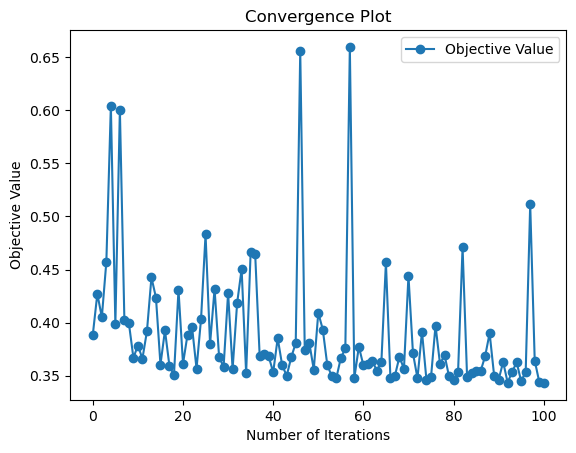

In [17]:
import numpy as np
from skopt import gp_minimize
#from skopt import forest_minimize
from skopt.space import Real
from skopt.utils import use_named_args

# Using Maximin Sampling (Greedy Algorithm)
from scipy.spatial.distance import cdist


initial_point_best = [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]

# Create bounds by adding/subtracting 0.5 and clamping to [0, 1]
#bound = [(max(0, val - 0.25), min(1, val + 0.25)) for val in initial_point_best]
bound = [(-0.25,1.25) for val in initial_point_best]
# Convert to skopt's Real dimensions for optimization
bounds = [Real(low, high, name=f"x{i}") for i, (low, high) in enumerate(bound)]
# Evaluate the objective function at these initial points
initial_values_best = objective_function(initial_point_best) 

initial_points = np.array(initial_point_best)
initial_values = np.array(initial_values_best)


# Define a callback function to print the current state
def print_progress(res):
    print(f"Iteration {len(res.x_iters)}")
    print(f"Current Best Parameters: {res.x}")
    print(f"Current Best Objective Value: {res.fun}")
    print("-" * 40)

# Convert the objective function to use named arguments
@use_named_args(bounds)
def wrapped_objective(**params):
    return objective_function(list(params.values()))

# Run Gaussian Process Optimization
result = gp_minimize(
    func=wrapped_objective,
    dimensions=bounds,
    n_calls=100,  # Total evaluations, including initial points
    n_initial_points=0,    
    x0=initial_points.tolist(),
    y0=initial_values.tolist(),
    random_state=42,
    callback=[print_progress]
)

# Display the results
print("Best objective value:", result.fun)
print("Best parameters:")
for i, param in enumerate(result.x):
    print(f"x{i+1}: {param:.4f}")
print(result.x)

# Visualize progress of the optimization
import matplotlib.pyplot as plt
plt.plot(result.func_vals, marker='o', label="Objective Value")
plt.xlabel("Number of Iterations")
plt.ylabel("Objective Value")
plt.title("Convergence Plot")
plt.legend()
plt.show()


### Current best after GP
Using GPR and FRF in obj fuunction
- [0.3944990304605307, 1.033758294901598, 0.3815612076582021, 0.26777773873791544, 0.9997309650399242, 0.3003133329020009, 0.4839177169613853, 0.9776438321497958, 0.13412867646014098]
Using only FRF in obj function
- [1.25, -0.25, 1.25, -0.25, -0.25, 1.0522356632431173, 1.25, -0.25, 0.13608107750956056]

### Validation of the final result

In [ ]:
import os
from IPython.display import clear_output

DOE_info = {}
vary_ratio = 0.5
cut_freq_high = 40

x_best1 =  [ 1.0,        0.5,       0.5,           0,         0.5,        0.68722604,
            0.5,        0.5,       0.69845997,    0,         0.85229155, 0.5,
            0.5,        0.5,       0.5,           0.5,       0.5,        0.6,
            0.59828352]

x_best2 = [ 0.88901592, 0.27044889, 0.28554261, 0.01408451, 0.27367161, 0.7319021,
            0.72747765, 0.41692908, 0.21476516, 0.25659874, 0.61753642, 0.7479544,
            0.7999774 , 0.40522151, 0.62167283, 0.75864746, 0.65032564, 0.5237532,
            0.66511448]

x_best_trial_04853 = [0.8066767551956717, 0.09692069778182295, 0.8325449913333602, 0.21048132516462145, 0.0, 0.6727064043755804, 0.24677257381072, 0.5730031436947602, 0.48020306862804085, 0.8479644185084424, 0.4590951072007893, 0.0, 0.6599936708355071, 0.29010755107378927, 0.7538300170833288, 0.0, 0.6957457662851698, 0.6823013244029553, 0.46385322880717933]
x_best_trail_03148 = [0.863642698252246, 0.7494195145402561, 0.8955970255486806, 0.14818889415764658, 0.555311219588681, 0.711934204161282, 0.7571933518469833, 0.8486787308791819, 0.26263069774387404, 0.7294790051229946, 0.6809443301995914, 0.04053136165183604, 0.6344951772338517, 0.9590229005506244, 0.4587779472965176, 0.673689822702624, 0.6303936220560132, 0.6746004441010262, 0.5465751085388425]

x_oriignal = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

#X_input =  [0.84507014, 0.5        ,0.5        ,0.50633148 ,0.1885995  ,0.75976072,
#            0.5       , 0.5        ,0.21309783 ,0.5        ,0.66487426 ,0.5       ,
#            0.5       , 0.5        ,0.5        ,0.35020139 ,0.35176575 ,0.54754628,
#            0.5       ]

X_input = [0.87104107 ,0.5        ,0.5        ,0.47295272 ,0.13602528 ,0.7609705,
           0.5        ,0.5        ,0.29578253 ,0.5        ,0.69371847 ,0.5,
           0.5        ,0.5        ,0.5        ,0.3958753  ,0.3276252  ,0.55483759,
           0.5       ]
X_input = np.array(X_input)
# The result.x is from the best result of gp_minimize()
X_input[1]  = result.x[0]
X_input[2]  = result.x[1]
X_input[6]  = result.x[2]
X_input[7]  = result.x[3]
X_input[9]  = result.x[4]
X_input[11] = result.x[5]
X_input[12] = result.x[6]
X_input[13] = result.x[7]
X_input[14] = result.x[8]
X_input[18] = result.x[9]

#x_best = result.x
#x_best = np.array(x_top_10_candidates)
x_best = X_input
# Transform X from [0,1] to [-1,1]
#X_transformed = 2 * result.x - 1
X_transformed = 2 * x_best - 1
X_transformed = X_transformed.reshape(-1,1)
X_transformed = np.transpose(X_transformed)
i_doe = 0
X_doe_transformed = X_transformed

# Parameter list    = [slab ,corridor, ground, edge_wall, inner_wall, stair ]
# Parameter list    = [ vs,   rho,   nu ]
t_para   = np.array([ 0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0],
                      0.8  + vary_ratio*(0.8  )*X_transformed[i_doe,1],
                      0.05 + vary_ratio*(0.05 )*X_transformed[i_doe,2],
                      0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,3],
                      0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,4],
                      0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0]])
#
e_para   = np.array([ 20e9 + vary_ratio*20e9*X_transformed[i_doe,5],
                      20e9 + vary_ratio*20e9*X_transformed[i_doe,6],
                      20e9 + vary_ratio*20e9*X_transformed[i_doe,7],
                      20e9 + vary_ratio*20e9*X_transformed[i_doe,8],
                      20e9 + vary_ratio*20e9*X_transformed[i_doe,9],
                      20e9 + vary_ratio*20e9*X_transformed[i_doe,5]])
#
nu_para  = np.array([ 0.27,
                      0.27,
                      0.27,
                      0.27,
                      0.27,
                      0.27])
#
rho_para = np.array([ 2300 + vary_ratio*2300*X_transformed[i_doe,10],
                      2300 + vary_ratio*2300*X_transformed[i_doe,11],
                      2300 + vary_ratio*2300*X_transformed[i_doe,12],
                      2300 + vary_ratio*2300*X_transformed[i_doe,13],
                      2300 + vary_ratio*2300*X_transformed[i_doe,14],
                      2300 + vary_ratio*2300*X_transformed[i_doe,10]])
#
soil_para = np.array([ 350  + vary_ratio*(350 )*X_transformed[i_doe,15],
                       1400 + vary_ratio*(1400)*X_transformed[i_doe,16],
                       0.33 ])
#
height_b            = 3.37 + vary_ratio*3.37*X_transformed[i_doe,17]
damp_ratio_b        = 0.045+ 0.01*X_transformed[i_doe,18]
tol = 0.3

# Start the simulation 
simu_tk.mapdl.clear()
simu_tk.setting_parameter(bool_SSI= True,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
simu_tk.build_model()
# Excitation point: Hammer 2.1 Pos1 (close to edge)
simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
simu_tk.mapdl.nsel('R','LOC','X',12.776-tol,12.776+tol)
nsel_id_3 = simu_tk.mapdl.nsel('R','LOC','Y',2.748-tol,2.748+tol)
simu_tk.mapdl.nsel('ALL')
# Apply the force on selected node and solve 
simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=cut_freq_high ,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_3[1])
modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
## Get FRF at target point
meas_FRFs_ex221 = simu_tk.get_FRFs_meas_EXAMPLE()
DOE_info_ex221 = {
    'id':i_doe,
    'X':x_best.tolist(),
    'X_trans':X_doe_transformed.tolist(),
    't_info':simu_tk.t_arr.tolist(),
    'e_info':simu_tk.e_arr.tolist(),
    'n_info':simu_tk.nu_arr.tolist(),
    'r_info':simu_tk.rho_arr.tolist(),
    's_info':simu_tk.soil_arr.tolist(),
    'height':simu_tk.height,
    'dr':simu_tk.Damping_ratio,
    'modal_info':modal_info,
    'meas_frf':meas_FRFs_ex221
    }
simu_tk.mapdl.clear()



simu_tk.setting_parameter(bool_SSI= True,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
simu_tk.build_model()
# Excitation point: Hammer 2.0 Pos2 (sensor)
simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
simu_tk.mapdl.nsel('R','LOC','X',7.19-tol,7.19+tol)
nsel_id_2 = simu_tk.mapdl.nsel('R','LOC','Y',8.14-tol,8.14+tol)
simu_tk.mapdl.nsel('ALL')
# Apply the force on selected node and solve 
simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=cut_freq_high ,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_2[1])
modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
## Get FRF at target point
meas_FRFs_ex220 = simu_tk.get_FRFs_meas_EXAMPLE()
DOE_info_ex220 = {
    'id':i_doe,
    'X':x_best.tolist(),
    'X_trans':X_doe_transformed.tolist(),
    't_info':simu_tk.t_arr.tolist(),
    'e_info':simu_tk.e_arr.tolist(),
    'n_info':simu_tk.nu_arr.tolist(),
    'r_info':simu_tk.rho_arr.tolist(),
    's_info':simu_tk.soil_arr.tolist(),
    'height':simu_tk.height,
    'dr':simu_tk.Damping_ratio,
    'modal_info':modal_info,
    'meas_frf':meas_FRFs_ex220
    }
simu_tk.mapdl.clear()



simu_tk.setting_parameter(bool_SSI= True,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
simu_tk.build_model()
# Excitation point: Hammer 2.0 Pos1 (shaker)
simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
simu_tk.mapdl.nsel('R','LOC','X',9.3-tol,9.3+tol)
nsel_id_1 = simu_tk.mapdl.nsel('R','LOC','Y',5.9-tol,5.9+tol)
simu_tk.mapdl.nsel('ALL')
# Apply the force on selected node and solve 
simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=cut_freq_high ,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_1[1])
modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
## Get FRF at target point
meas_FRFs_ex22 = simu_tk.get_FRFs_meas_EXAMPLE()
DOE_info_ex22 = {
    'id':i_doe,
    'X':x_best.tolist(),
    'X_trans':X_doe_transformed.tolist(),
    't_info':simu_tk.t_arr.tolist(),
    'e_info':simu_tk.e_arr.tolist(),
    'n_info':simu_tk.nu_arr.tolist(),
    'r_info':simu_tk.rho_arr.tolist(),
    's_info':simu_tk.soil_arr.tolist(),
    'height':simu_tk.height,
    'dr':simu_tk.Damping_ratio,
    'modal_info':modal_info,
    'meas_frf':meas_FRFs_ex22
    }

simu_tk.mapdl.clear()
clear_output(wait=True)

print(DOE_info_ex22['t_info'])
print(DOE_info_ex22['e_info'])
print(DOE_info_ex22['r_info'])
print(DOE_info_ex22['s_info'])
print(DOE_info_ex22['height'])
print(DOE_info_ex22['dr'])




### Visualization
- same as above code, just use for Visualization in convience.

In [14]:
def objective_function_validation(X_input):
    
    cut_freq_low = 8
    cut_freq_high = 50
    vary_ratio = 0.5
    X_transformed = 2 * X_input - 1
    X_transformed = X_transformed.reshape(-1,1)
    X_transformed = np.transpose(X_transformed)
    i_doe = 0
    X_doe_transformed = X_transformed
    #
    # Parameter list    = [slab ,corridor, ground, edge_wall, inner_wall, stair ]
    # Parameter list    = [ vs,   rho,   nu ]
    t_para   = np.array([ 0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0],
                        0.8  + vary_ratio*(0.8  )*X_transformed[i_doe,1],
                        0.05 + vary_ratio*(0.05 )*X_transformed[i_doe,2],
                        0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,3],
                        0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,4],
                        0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0]])
    #
    e_para   = np.array([ 20e9 + vary_ratio*20e9*X_transformed[i_doe,5],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,6],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,7],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,8],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,9],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,5]])
    #
    nu_para  = np.array([ 0.27,
                        0.27,
                        0.27,
                        0.27,
                        0.27,
                        0.27])
    #
    rho_para = np.array([ 2300 + vary_ratio*2300*X_transformed[i_doe,10],
                        2300 + vary_ratio*2300*X_transformed[i_doe,11],
                        2300 + vary_ratio*2300*X_transformed[i_doe,12],
                        2300 + vary_ratio*2300*X_transformed[i_doe,13],
                        2300 + vary_ratio*2300*X_transformed[i_doe,14],
                        2300 + vary_ratio*2300*X_transformed[i_doe,10]])
    #
    soil_para = np.array([ 350  + vary_ratio*(350 )*X_transformed[i_doe,15],
                        1400 + vary_ratio*(1400)*X_transformed[i_doe,16],
                        0.33 ])
    #
    height_b            = 3.37 + vary_ratio*3.37*X_transformed[i_doe,17]
    damp_ratio_b        = 0.045+ 0.01*X_transformed[i_doe,18]
    tol = 0.3
    #
    #
    # Start the simulation 
    simu_tk.mapdl.clear()
    simu_tk.setting_parameter(bool_SSI= False,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()
    # Excitation point: Hammer 2.1 Pos1 (close to edge)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',12.776-tol,12.776+tol)
    nsel_id_3 = simu_tk.mapdl.nsel('R','LOC','Y',2.748-tol,2.748+tol)
    simu_tk.mapdl.nsel('ALL')
    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=cut_freq_high,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_3[1])
    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
    ## Get FRF at target point
    meas_FRFs_ex221 = simu_tk.get_FRFs_meas_EXAMPLE()
    DOE_info_ex221 = {
        'id':i_doe,
        'X':X_input.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs_ex221
        }
    simu_tk.mapdl.clear()
    #
    #
    simu_tk.setting_parameter(bool_SSI= False,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()
    # Excitation point: Hammer 2.0 Pos2 (sensor)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',7.19-tol,7.19+tol)
    nsel_id_2 = simu_tk.mapdl.nsel('R','LOC','Y',8.14-tol,8.14+tol)
    simu_tk.mapdl.nsel('ALL')
    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=cut_freq_high,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_2[1])
    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
    ## Get FRF at target point
    meas_FRFs_ex220 = simu_tk.get_FRFs_meas_EXAMPLE()
    DOE_info_ex220 = {
        'id':i_doe,
        'X':X_input.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs_ex220
        }
    simu_tk.mapdl.clear()
    #
    #
    simu_tk.setting_parameter(bool_SSI= False,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()
    # Excitation point: Hammer 2.0 Pos1 (shaker)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',9.3-tol,9.3+tol)
    nsel_id_1 = simu_tk.mapdl.nsel('R','LOC','Y',5.9-tol,5.9+tol)
    simu_tk.mapdl.nsel('ALL')
    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=cut_freq_high,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_1[1])
    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
    ## Get FRF at target point
    meas_FRFs_ex22 = simu_tk.get_FRFs_meas_EXAMPLE()
    DOE_info_ex22 = {
        'id':i_doe,
        'X':X_input.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs_ex22
        }
    #
    simu_tk.mapdl.clear()
    #clear_output(wait=True)
    #
    freq_resample = np.linspace(0, cut_freq_high, 101)
    FRFs_simu = np.zeros([24,len(freq_resample)])
    #
    i_ch_index = 0
    ch_list = [9,10,11,12,3,13,14,15]
    # Case 221
    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(DOE_info_ex221['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(DOE_info_ex221['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1
    # Case 220
    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(DOE_info_ex220['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(DOE_info_ex220['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1
    # Case 22
    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(DOE_info_ex22['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(DOE_info_ex22['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1
    #
    # Split into 3 groups of [8, 101]
    num_groups = 3
    group_size = 8
    normalized_data = np.zeros_like(FRFs_simu)
    #
    for i in range(num_groups):
        # Get the current group
        start_idx = i * group_size
        end_idx = start_idx + group_size
        group = FRFs_simu[start_idx:end_idx, :]  # Shape: [8, 101]
        # Compute normalization value (e.g., max of the group)
        normalization_value = np.max(np.abs(group))
        # Normalize the group
        normalized_data[start_idx:end_idx, :] = group / normalization_value
    #FRFs_simu_norm = FRFs_simu/np.max(np.abs(FRFs_simu))
    FRFs_simu_norm = normalized_data
    #
    #
    ####################################################################################################################################################
    # Import measurement data
    FRFs_exp = np.zeros([24,len(freq_resample)])
    #
    i_pos_1OG = [9,10,11,12,3,13,14,15]
    #cut_freq_low = 8
    #cut_freq_high = 50
    #
    i_file = 9
    directory = os.path.join(project_dir, "MATLAB/Surrogate_main/FRF/")
    for i in range(len(i_pos_1OG)):
        i_pos = i_pos_1OG[i]
        filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
        full_path = os.path.join(directory, filename)
        frf_data = sio.loadmat(full_path)
        f = np.array([frf_data["freq_"]])[0]
        #r = np.array([frf_data["real_"]])[0]
        imag = np.array([frf_data["imag_"]])[0]
        indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
        indices_cutoff_high = np.where((f >= 40 ))[0]
        id_last = indices[-1] 
        id_start = indices[0] 
        f = f[0:id_last]
        #r = r[0:id_last]
        imag = imag[0:id_last]
        imag[0: id_start] = 0
        imag[indices_cutoff_high[0]:id_last] = 0
        i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
        FRFs_exp[i,:] = i_resample
    #
    i_file = 1
    for i in range(len(i_pos_1OG)):
        i_pos = i_pos_1OG[i]
        filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
        full_path = os.path.join(directory, filename)
        frf_data = sio.loadmat(full_path)
        f = np.array([frf_data["freq_"]])[0]
        #r = np.array([frf_data["real_"]])[0]
        imag = np.array([frf_data["imag_"]])[0]
        indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
        indices_cutoff_high = np.where((f >= 40 ))[0]
        id_last = indices[-1] 
        id_start = indices[0] 
        f = f[0:id_last]
        #r = r[0:id_last]
        imag = imag[0:id_last]
        imag[0: id_start] = 0
        imag[indices_cutoff_high[0]:id_last] = 0
        i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
        FRFs_exp[i+8,:] = i_resample
    #
    i_file = 13
    for i in range(len(i_pos_1OG)):
        i_pos = i_pos_1OG[i]
        filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
        full_path = os.path.join(directory, filename)
        frf_data = sio.loadmat(full_path)
        f = np.array([frf_data["freq_"]])[0]
        #r = np.array([frf_data["real_"]])[0]
        imag = np.array([frf_data["imag_"]])[0]
        indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
        indices_cutoff_high = np.where((f >= 40 ))[0]
        id_last = indices[-1] 
        id_start = indices[0] 
        f = f[0:id_last]
        #r = r[0:id_last]
        imag = imag[0:id_last]
        imag[0: id_start] = 0
        imag[indices_cutoff_high[0]:id_last] = 0
        i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
        FRFs_exp[i+16,:] = i_resample
    #
    # Split into 3 groups of [8, 101]
    num_groups = 3
    group_size = 8
    normalized_data = np.zeros_like(FRFs_exp)
    #
    for i in range(num_groups):
        # Get the current group
        start_idx = i * group_size
        end_idx = start_idx + group_size
        group = FRFs_exp[start_idx:end_idx, :]  # Shape: [8, 101]
        # Compute normalization value (e.g., max of the group)
        normalization_value = np.max(np.abs(group))
        # Normalize the group
        normalized_data[start_idx:end_idx, :] = group / normalization_value
    #FRFs_simu_norm = FRFs_simu/np.max(np.abs(FRFs_simu))
    FRFs_exp_norm = normalized_data
    #FRFs_exp_norm = FRFs_exp/np.max(np.abs(FRFs_exp))

    color_list = ['red', 'blue', 'green', 'orange']

    for i in range(0,4):
        #plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="--",color='blue', alpha=0.5)
        plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="-.",color=color_list[i], alpha=0.5)
        plt.plot(freq_resample,FRFs_exp_norm[i,:], label=f"ch_{i}_exp",linestyle=":",color=color_list[i], alpha=0.5)
        plt.legend()
        plt.xlabel("freq (Hz)")
        plt.ylabel("Normalized imaginary part")
        plt.title("1OG, Comparison of simulation and hammer test, ex 221")
    plt.show()
    for i in range(4,8):
        #plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="--",color='blue', alpha=0.5)
        plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="-.",color=color_list[i-4], alpha=0.5)
        plt.plot(freq_resample,FRFs_exp_norm[i,:], label=f"ch_{i}_exp",linestyle=":",color=color_list[i-4], alpha=0.5)
        plt.legend()
        plt.xlabel("freq (Hz)")
        plt.ylabel("Normalized imaginary part")
        plt.title("2OG, Comparison of simulation and hammer test, ex 221")
    plt.show()
    for i in range(8,12):
        #plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="--",color='blue', alpha=0.5)
        plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="-.",color=color_list[i-8], alpha=0.5)
        plt.plot(freq_resample,FRFs_exp_norm[i,:], label=f"ch_{i}_exp",linestyle=":",color=color_list[i-8], alpha=0.5)
        plt.legend()
        plt.xlabel("freq (Hz)")
        plt.ylabel("Normalized imaginary part")
        plt.title("1OG, Comparison of simulation and hammer test, ex 220")
    plt.show()
    for i in range(12,16):
        #plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="--",color='blue', alpha=0.5)
        plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="-.",color=color_list[i-12], alpha=0.5)
        plt.plot(freq_resample,FRFs_exp_norm[i,:], label=f"ch_{i}_exp",linestyle=":",color=color_list[i-12], alpha=0.5)
        plt.legend()
        plt.xlabel("freq (Hz)")
        plt.ylabel("Normalized imaginary part")
        plt.title("2OG, Comparison of simulation and hammer test, ex 220")
    plt.show()
    for i in range(16,20):
        #plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="--",color='blue', alpha=0.5)
        plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="-.",color=color_list[i-16], alpha=0.5)
        plt.plot(freq_resample,FRFs_exp_norm[i,:], label=f"ch_{i}_exp",linestyle=":",color=color_list[i-16], alpha=0.5)
        plt.legend()
        plt.xlabel("freq (Hz)")
        plt.ylabel("Normalized imaginary part")
        plt.title("1OG, Comparison of simulation and hammer test, ex 22")
    plt.show()
    for i in range(20,24):
        #plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="--",color='blue', alpha=0.5)
        plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="-.",color=color_list[i-20], alpha=0.5)
        plt.plot(freq_resample,FRFs_exp_norm[i,:], label=f"ch_{i}_exp",linestyle=":",color=color_list[i-20], alpha=0.5)
        plt.legend()
        plt.xlabel("freq (Hz)")
        plt.ylabel("Normalized imaginary part")
        plt.title("2OG, Comparison of simulation and hammer test, ex 22")
    plt.show()

[ 0.91831499  1.25       -0.25        0.15683994  0.31580221  0.77003739
  1.25       -0.25        0.10753501  0.39957796  0.7630694  -0.25
  1.05223566  1.25       -0.25        0.5         0.5         0.49754582
  0.13608108]
 Setting information
     Building inner wall           :  True
     Building stair                :  True
     Building SSI                  :  False
     Element size                  :  0.4
     Height of building            :  3.3617294134
 Assigning parameter
     Rewrite thickness by input
     Rewrite Young's modulus by input
     Rewrite Poisson's ratio by input
     Rewrite Density by input
     Rewrite soil properties by input
 /PREP7 activated
     /PREP7 finished, duration 6.2402 seconds.
Solve model: /SOLU
 Setting information
     Solution type                 :  6
     Start frequency               :  0.001
     End frequency                 :  50
     Freqency increment            :  1
     Number of modes (solu_type=2) :  40
     Damping ratio   

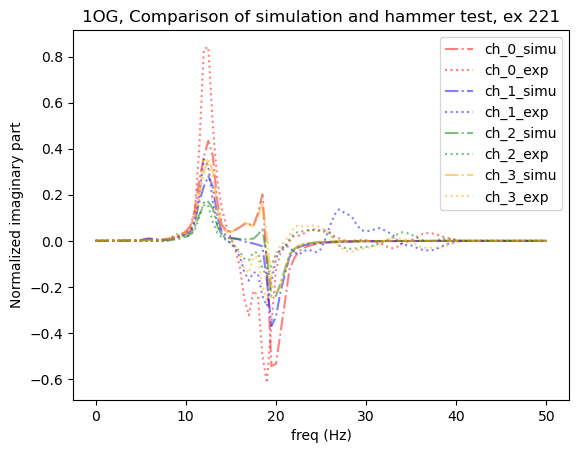

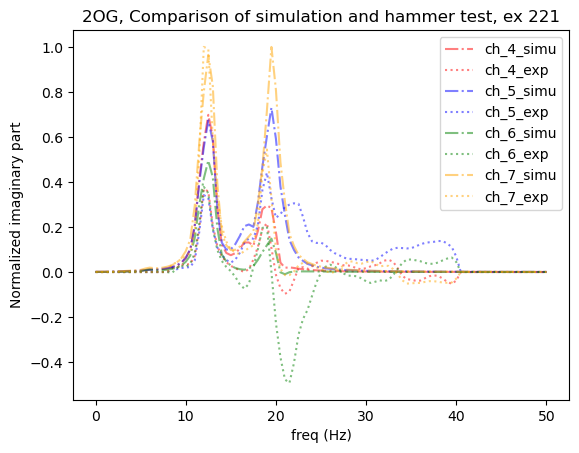

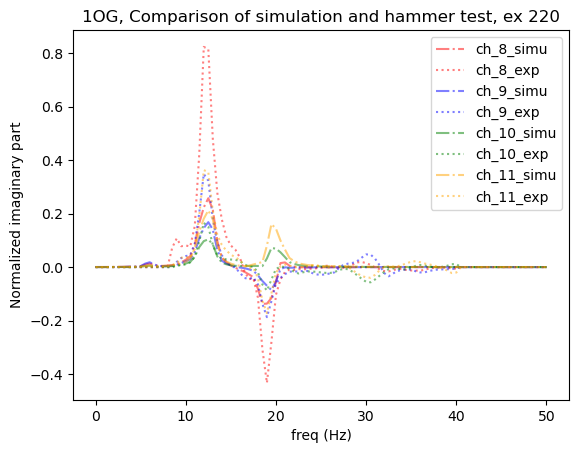

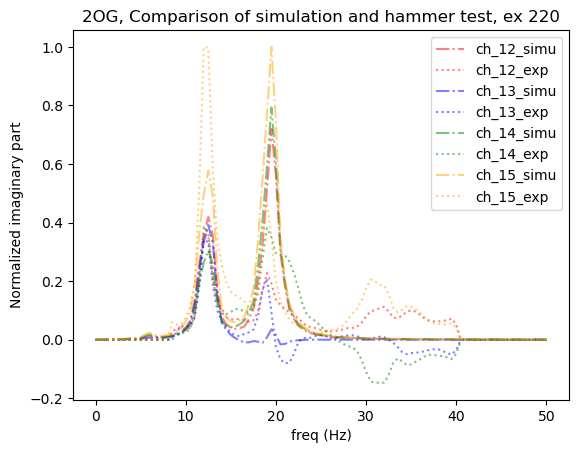

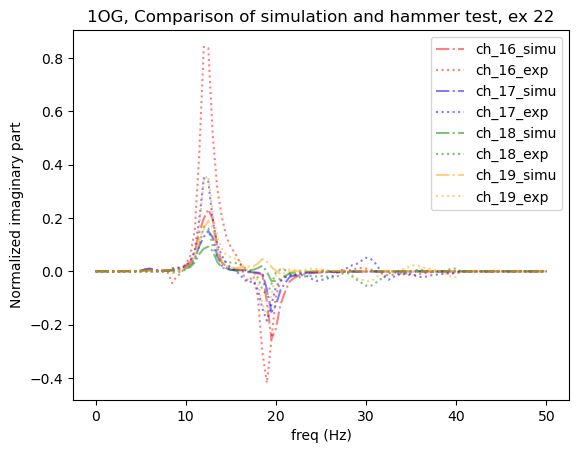

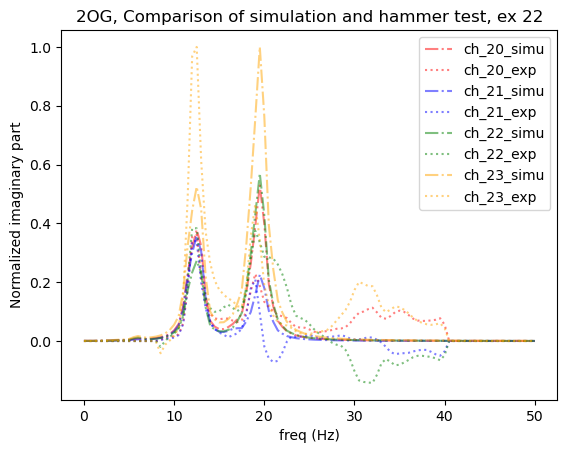

In [18]:
X_input = [0.91831499, 0.5,0.5,0.15683994, 0.31580221, 0.77003739,0.5,  0.5, 0.10753501, 0.39957796, 0.7630694, 0.5,0.5, 0.5,0.5, 0.5,0.5, 0.49754582,0.5 ]
X_input = np.array(X_input)
X_input[1]  = result.x[0]
X_input[2]  = result.x[1]
X_input[6]  = result.x[2]
X_input[7]  = result.x[3]
X_input[11] = result.x[4]
X_input[12] = result.x[5]
X_input[13] = result.x[6]
X_input[14] = result.x[7]
X_input[18] = result.x[8]
print(X_input)
objective_function_validation(np.array(X_input))